In [1]:
'''
Date: 24/Jan/2022
Auther: Yike Xie
Content: Figure 4 in dengue paper
'''

'\nDate: 24/Jan/2022\nAuther: Yike Xie\nContent: Figure 4 in dengue paper\n'

In [2]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import *    

In [3]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/final/modules') 
import YK_util, optimized_pair_comparison, functions_CCC_figure_fra_pair
from YK_util import *
from optimized_pair_comparison import *
from functions_CCC_figure_fra_pair import *

In [4]:
# load data
path = '/home/yike/phd/dengue/data/mergedata_20211001.h5ad'
adata = sc.read_h5ad(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid, log1p=True) # log1p = 2
adata_kid = removegenes(adata_kid)
adata_kid = adata_kid[(adata_kid.obs.cell_subtype_new != 'doublets') & 
                        (adata_kid.obs.cell_subtype_new != 'unknown')].copy()

sc.pp.filter_genes(adata_kid, min_cells=3)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [5]:
#rename and reorder some celltypes 
adata_kid = adata_kid.copy()
reorg_celltype(adata_kid) # 'cell_type_new', 'cell_subtype_new'

In [6]:
#save path
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/figure_4/'
save_tables = '/home/yike/phd/dengue/docs/paper_draft/tabels/'

In [7]:
# get cell types and cell subtypes
cell_types = adata_kid.obs['cell_type_new'].unique().tolist()
cell_subtypes = adata_kid.obs['cell_subtype_new'].unique().tolist()

In [8]:
# load cell type palette
ct_palette = load_ct_palette()
print([ct for ct in ct_palette.keys()])
sns.color_palette(ct_palette.values())

['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'Monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [9]:
# load cell subtype palette
cst_palette = load_cst_palette()
print([cst for cst in cst_palette.keys()])
sns.color_palette(cst_palette.values())

['memory B cells', 'naive B cells', 'activated B cells', 'proliferating plasmablasts', 'non-proliferating plasmablasts', 'CD4+ T cells', 'CD8+ effector T cells', 'CD8+ naive/memory T cells', 'signaling NK cells', 'cytotoxic NK cells', 'classical monocytes', 'non-classical monocytes', 'intermediate monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(1.0, 0.0, 0.0),
 (0.7372549019607844, 0.5607843137254902, 0.5607843137254902),
 (0.5019607843137255, 0.0, 0.0),
 (1.0, 0.8941176470588236, 0.7686274509803922),
 (1.0, 0.5490196078431373, 0.0),
 (0.6901960784313725, 0.7686274509803922, 0.8705882352941177),
 (0.2549019607843137, 0.4117647058823529, 0.8823529411764706),
 (0.0, 0.0, 0.5019607843137255),
 (0.5019607843137255, 0.0, 0.5019607843137255),
 (0.8666666666666667, 0.6274509803921569, 0.8666666666666667),
 (0.5607843137254902, 0.7372549019607844, 0.5607843137254902),
 (0.5647058823529412, 0.9333333333333333, 0.5647058823529412),
 (0.0, 0.5019607843137255, 0.0),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [10]:
def heatmap_cst(cst_pair, g_list, cst_order, vs_type='SD vs D', save_fd=False):
    #rcParams['figure.figsize']=(7, 14)
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    
    df = cst_pair.reset_index().set_index('gene').loc[g_list][['cell_subtype', 'med_pair']]

    df_new = pd.DataFrame(np.zeros([len(df.index.unique()), len(cst_order)]), columns=cst_order, index=g_list)

    for idx in df_new.index:    
        for col in df_new.columns:
            df_new.at[idx, col] = df.loc[idx][df.loc[idx]['cell_subtype'] == col]['med_pair'][0]
            
    df_new = pd.DataFrame(np.clip(df_new.values, -3.5, 3.5), columns=df_new.columns, index=df_new.index)
    
    fig, ax = plt.subplots(figsize=[1 + 1.5 * len(cst_order), 0.5 * len(g_list)])
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    
    ax = sns.heatmap(df_new, cmap=cmap, center=0, yticklabels=True, vmin=-3.5, vmax=3.5,
                     cbar_kws={'label': 'log2 fold change\n[%s]'%vs_type, 'shrink': .3})
    ax.set_ylabel(None)
    
    xlabels = [label.get_text().replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels)

    if save_fd is not False:
        fig.savefig(save_figures + save_fd, bbox_inches='tight')

    return {'figure': fig, 'ax': ax}

def pairwise_boxplot(FCs_data, cell_subtype, genes, path=False):
    
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    box_data = FCs_data.loc[cell_subtype][genes]
    
    cmap = mpl.cm.get_cmap('coolwarm')
    norm = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)
    palette = [cmap(norm(x)) for x in np.clip(box_data.median(axis=0), -2.5, 2.5)]
    
    box_data = pd.melt(box_data)
    
    fig, ax = plt.subplots(figsize=(6, len(genes)*0.35 + 1))
    sns.boxplot(data = box_data, y = 'variable', x = 'value', palette = palette, width=0.8,
                orient = 'h', linewidth=1, ax=ax)
    
    ax.set(ylabel = None, xlim = (-11, 11))
    ax.set_yticklabels(genes)
    
    ax.set_xlabel('log2 fold change')
    
    ax_cb = fig.add_axes([0.25, 0, 0.5, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks([-2, -1, 0, 1, 2])
    cbar.set_ticklabels(['-2', '-1', '0', '1', '2'])
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label('log2 fold change', fontsize=15)

    for x in [-1, 0, 1]:
        ax.axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    
    if path is not False:
        fig.savefig(save_figures + path, bbox_inches='tight')
        
    return {'figure': fig, 'ax': ax}

def annanote_adult(adata_adult): 
    adata_adult.obs['cell_type_new'] = adata_adult.obs['cell_type']
    adata_adult.obs['cell_type_new'] = adata_adult.obs['cell_type_new'].astype('object')
    adata_adult.obs['cell_subtype_new'] = adata_adult.obs['cell_subtype_new'].astype('object')
    
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'NK_cells', 'cell_type_new'] = 'NK cells'
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'B_cells', 'cell_type_new'] = 'B cells'
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'T_cells', 'cell_type_new'] = 'T cells'
    ####################################
    
    for gene in ['GZMA',  'NKG7', 'GNLY', 'XCL1', 'XCL2', 'FCGR3A', 'CCND2', 'MKI67']:
            adata_adult.obs[gene] = (adata_adult[:, gene].X.toarray() > 0)
    
    ####################  
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'NK cells', 'cell_type_new'] = 'NK_unknown'
    idx_NK = ((adata_adult.obs['cell_type_new'] == 'NK_unknown') &
             (adata_adult.obs['GZMA'] == True) &
             (adata_adult.obs['NKG7'] == True) &
             (adata_adult.obs['GNLY'] == True) )
    adata_adult.obs.loc[idx_NK, 'cell_type_new'] = 'NK cells'
    
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'NK cells', 'cell_subtype_new'] = 'cytotoxic NK cells'
    idx_sig_NK = ((adata_adult.obs['cell_type_new'] == 'NK cells') & 
                        (adata_adult.obs['XCL1'] == True) & 
                        (adata_adult.obs['XCL2'] == True) &
                        (adata_adult.obs['FCGR3A'] == True))
    adata_adult.obs.loc[idx_sig_NK, 'cell_subtype_new'] = 'signaling NK cells'
    
    ####################
    adata_adult.obs.loc[adata_adult.obs['cell_type_new'] == 'Plasmablasts', 'cell_subtype_new'] = 'non-proliferating plasmablasts'
    idx_P = ((adata_adult.obs['cell_type_new'] == 'Plasmablasts') & 
                        (adata_adult.obs['CCND2'] == True) & 
                        (adata_adult.obs['MKI67'] == True))
    adata_adult.obs.loc[idx_P, 
                        'cell_subtype_new'] = 'proliferating plasmablasts'
    
    ####################
    adata_adult.obs['cell_type_new'] = adata_adult.obs['cell_type_new'].astype('category')
    adata_adult.obs['cell_subtype_new'] = adata_adult.obs['cell_subtype_new'].astype('category')    
    return adata_adult

def pairwise_processing(df_kid, df_adult):
    ###### merge two df
    intersect = [x for x in df_kid.index if x in df_adult.index]
    df_adult.columns = [col+'_a' for col in df_adult.columns]
    df_kid = df_kid[['med_pair', 'fra_pair', 'neg_fra_pair']]
    df_adult = df_adult[['med_pair_a', 'fra_pair_a', 'neg_fra_pair_a']]
    df = pd.concat([df_kid.loc[intersect], df_adult.loc[intersect]], axis=1)
    
    ###### define robost genes for kids, adults or both
    ind_kid = df[(df['fra_pair'] >= 39/56) | (df['neg_fra_pair'] >= 39/56)].index
    ind_adult = df[(df['fra_pair_a'] >= 39/56) | (df['neg_fra_pair_a'] >= 39/56)].index
    ind_merge = list(set(ind_kid) & set(ind_adult))
    
    df['outlier'] = 'no'
    df.loc[ind_kid, 'outlier'] = 'x_only'
    df.loc[ind_adult, 'outlier'] = 'y_only'
    df.loc[ind_merge, 'outlier'] = 'both'
    
    ###### calculate marker and distance
    df['x'] = df['med_pair'] - df['med_pair'].mean()
    df['y'] = df['med_pair_a'] - df['med_pair_a'].mean()
    df['r'] = np.sqrt(df['x'] ** 2 + df['y'] ** 2)
    
    ###### set markers for genes
    df_2 = df[df['r'] >= df['r'].quantile(q = 0.95)] 
    r = df_2.sort_values('r').iloc[0]['r']

    df['markers'] = 'no'
        
    df.loc[df_2[(df_2['x'] > 1) & (df_2['y'] > 1)].index, 'markers'] = '1'
    df.loc[df_2[(df_2['x'] < -1) & (df_2['y'] > 1)].index, 'markers'] = '2'
    df.loc[df_2[(df_2['x'] < -1) & (df_2['y'] < -1)].index, 'markers'] = '3'
    df.loc[df_2[(df_2['x'] > 1) & (df_2['y'] < -1)].index, 'markers'] = '4'

    df.loc[df_2[(df_2['x'] > 1) & (df_2['y'] < 1) & (df_2['y'] > -1)].index, 'markers'] = '5'
    df.loc[df_2[(df_2['y'] > 1) & (df_2['x'] < 1) & (df_2['x'] > -1)].index, 'markers'] = '6'
    df.loc[df_2[(df_2['x'] < -1) & (df_2['y'] < 1) & (df_2['y'] > -1)].index, 'markers'] = '7'
    df.loc[df_2[(df_2['y'] < -1) & (df_2['x'] < 1) & (df_2['x'] > -1)].index, 'markers'] = '8'
    return (df, r)

def scatter_pairwise(df, r, marklist, xlim=4.2, name=False):
    ###### plot scatter_pairwise
    
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    import matplotlib as mpl

    fig, ax = plt.subplots(figsize=(7, 7))
    
    
    sns.scatterplot(data=df, x='med_pair', y='med_pair_a', ax=ax, hue='markers', 
                     hue_order=['1', '2', '3', '4', '5', '6', '7', 'no','8'],
                     palette=sns.color_palette('tab10', 9), 
                     edgecolor='none', s=15)
    sns.kdeplot(x = 'med_pair', y = 'med_pair_a', data = df.loc[:,['med_pair', 'med_pair_a']], 
                ax = ax, linewidths=1)
    sns.set_style('ticks')

    mark_list = marklist
    for gene in mark_list:
        ax.text(df.loc[gene, 'med_pair']-0.6, 
        df.loc[gene, 'med_pair_a'] + 0.01,
        gene, color = 'black',
        fontsize = 16)

    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-xlim, xlim)

    # Draw 8 slices using Fabio's function 
    x_mean = df['med_pair'].mean()
    y_mean = df['med_pair_a'].mean()
    center = (x_mean, y_mean)

    draw_8_slices(ax, center, radius=r)

    #draw_8_slices(ax, center, radius=r)
    ax.set_xlabel('log2 fold change (SD vs D)\nin children')
    ax.set_ylabel('log2 fold change (SD vs D)\nin adults')

    #ax.set_title('Median log2 fold change of \npairwise comparison (SD vs D)', fontsize=10)
    ax.get_legend().remove()
    
    ticklabels = range(-int(xlim), int(xlim)+1, 2)
    ax.set_xticks(ticklabels)
    ax.set_yticks(ticklabels)
    ax.set_xticklabels(ticklabels)
    ax.set_yticklabels(ticklabels)
    
    if name is not False:
        filename = save_figures + name
        fig.savefig(filename, bbox_inches = 'tight')
    
    return {'figure': fig, 'ax': ax}

#Fabio's function
def draw_8_slices(ax, center, radius=1):
    def cp(amin, amax, center, ndots=100):
        xc, yc = center
        angles = np.linspace(amin, amax, ndots)
        xcircs, ycircs = xc + radius * np.cos(angles), yc + radius * np.sin(angles)
        return [(xi, yi) for xi, yi in zip(xcircs, ycircs)][::-1]

    def draw_wedge(ax, points, color):
        points = np.array(points)
        center = points.mean(axis=0)
        delta = points - center
        points = center + 0.99 * delta

        rgb = list(mpl.colors.to_rgba(color)[:-1])
        rgba_edge = tuple(rgb + [0.6])
        rgba_fill = tuple(rgb + [0.2])
        ax.add_artist(plt.Polygon(
            points, edgecolor='none', facecolor=rgba_fill, lw=0.2,
            clip_on=False,
            ))

    xc, yc = center
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # Cross
    for x in [xc]:
        ax.axvline(x, ls='--', color='k', lw=0.2, zorder=0.5)
        
    for y in [yc]:
        ax.axhline(y, ls='--', color='k', lw=0.2, zorder=0.5)
    
    #colors = sns.color_palette('pastel', 9)
    colors = mpl.cm.Pastel1(range(9))
    #colors = [tuple(list(mpl.colors.to_rgba(color))[:-1] + [0.2]) for color in colors]
    
    # Circle
    #rgb = list(mpl.colors.to_rgba(colors[7]))[:-1]
    circle = plt.Circle(center, radius, facecolor=tuple(list(colors[8])[:-1] + [0.1]), 
                        edgecolor=tuple(list(colors[8])[:-1] + [1]), lw=0.5, ls='--')
    ax.add_artist(circle)

    # Wedges
    #1. Intersections with axes border
    xbords, ybords = [], []
    xbords.append(xmax)
    ybords.append(yc + 1)
    xbords.append(xc + 1)
    ybords.append(ymax)
    xbords.append(xc - 1)
    ybords.append(ymax)
    xbords.append(xmin)
    ybords.append(yc + 1)
    xbords.append(xmin)
    ybords.append(yc - 1)
    xbords.append(xc - 1)
    ybords.append(ymin)
    xbords.append(xc + 1)
    ybords.append(ymin)
    xbords.append(xmax)
    ybords.append(yc - 1)

    bords = np.vstack([xbords, ybords]).T
    
    # 2. wedges functions
    def wedges(radius, ax):
        # intersections with circle
        angles = np.array([np.arcsin(1/radius), np.arccos(1/radius), np.pi-np.arccos(1/radius), 
                           np.pi - np.arcsin(1/radius), np.pi+np.arcsin(1/radius), 
                           np.pi+np.arccos(1/radius), 2*np.pi-np.arccos(1/radius), 
                           2*np.pi-np.arcsin(1/radius)])

        xcircs, ycircs = xc + radius * np.cos(angles), yc + radius * np.sin(angles)
        circs = np.vstack([xcircs, ycircs]).T
        
        # draw wedges
        draw_wedge(ax, [circs[0], bords[0], (xmax, ymax), bords[1], circs[1]] + cp(angles[0], angles[1], center), color=colors[0])
        draw_wedge(ax, [circs[1], bords[1], bords[2], circs[2]] + cp(angles[1], angles[2], center), color=colors[1])
        draw_wedge(ax, [circs[2], bords[2], (xmin, ymax), bords[3], circs[3]] + cp(angles[2], angles[3], center), color=colors[2])
        draw_wedge(ax, [circs[3], bords[3], bords[4], circs[4]] + cp(angles[3], angles[4], center), color=colors[3])
        draw_wedge(ax, [circs[4], bords[4], (xmin, ymin), bords[5], circs[5]] + cp(angles[4], angles[5], center), color=colors[4])
        draw_wedge(ax, [circs[5], bords[5], bords[6], circs[6]] + cp(angles[5], angles[6], center), color=colors[5])
        draw_wedge(ax, [circs[6], bords[6], (xmax, ymin), bords[7], circs[7]] + cp(angles[6], angles[7], center), color=colors[6])
        draw_wedge(ax, [circs[7], bords[7], bords[0], circs[0]] + cp(angles[7], 2*np.pi+angles[0], center), color=colors[7])
        
    # 3. draw wedges
    wedges(radius, ax)

In [11]:
ct_pair = pd.read_csv(save_tables + 'ct_pairwise_cut0.1.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
ct_log2FC = pd.read_csv(save_tables + 'ct_logFCs_cut0.1.tsv', sep='\t', index_col=0)

cst_pair = pd.read_csv(save_tables + 'cst_pairwise_cut0.1.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
cst_log2FC = pd.read_csv(save_tables + 'cst_logFCs_cut0.1.tsv', sep='\t', index_col=0)




cst_pair_a = pd.read_csv(save_tables + 'adult_cst_pair.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
cst_log2FC_a = pd.read_csv(save_tables + 'adult_cst_log2FC.tsv', sep='\t', index_col=0)

ct_pair_a = pd.read_csv(save_tables + 'adult_ct_pair.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
ct_log2FC_a = pd.read_csv(save_tables + 'adult_ct_log2FC.tsv', sep='\t', index_col=0)

{'figure': <Figure size 1800x2505 with 2 Axes>,
 'ax': <AxesSubplot:xlabel='log2 fold change'>}

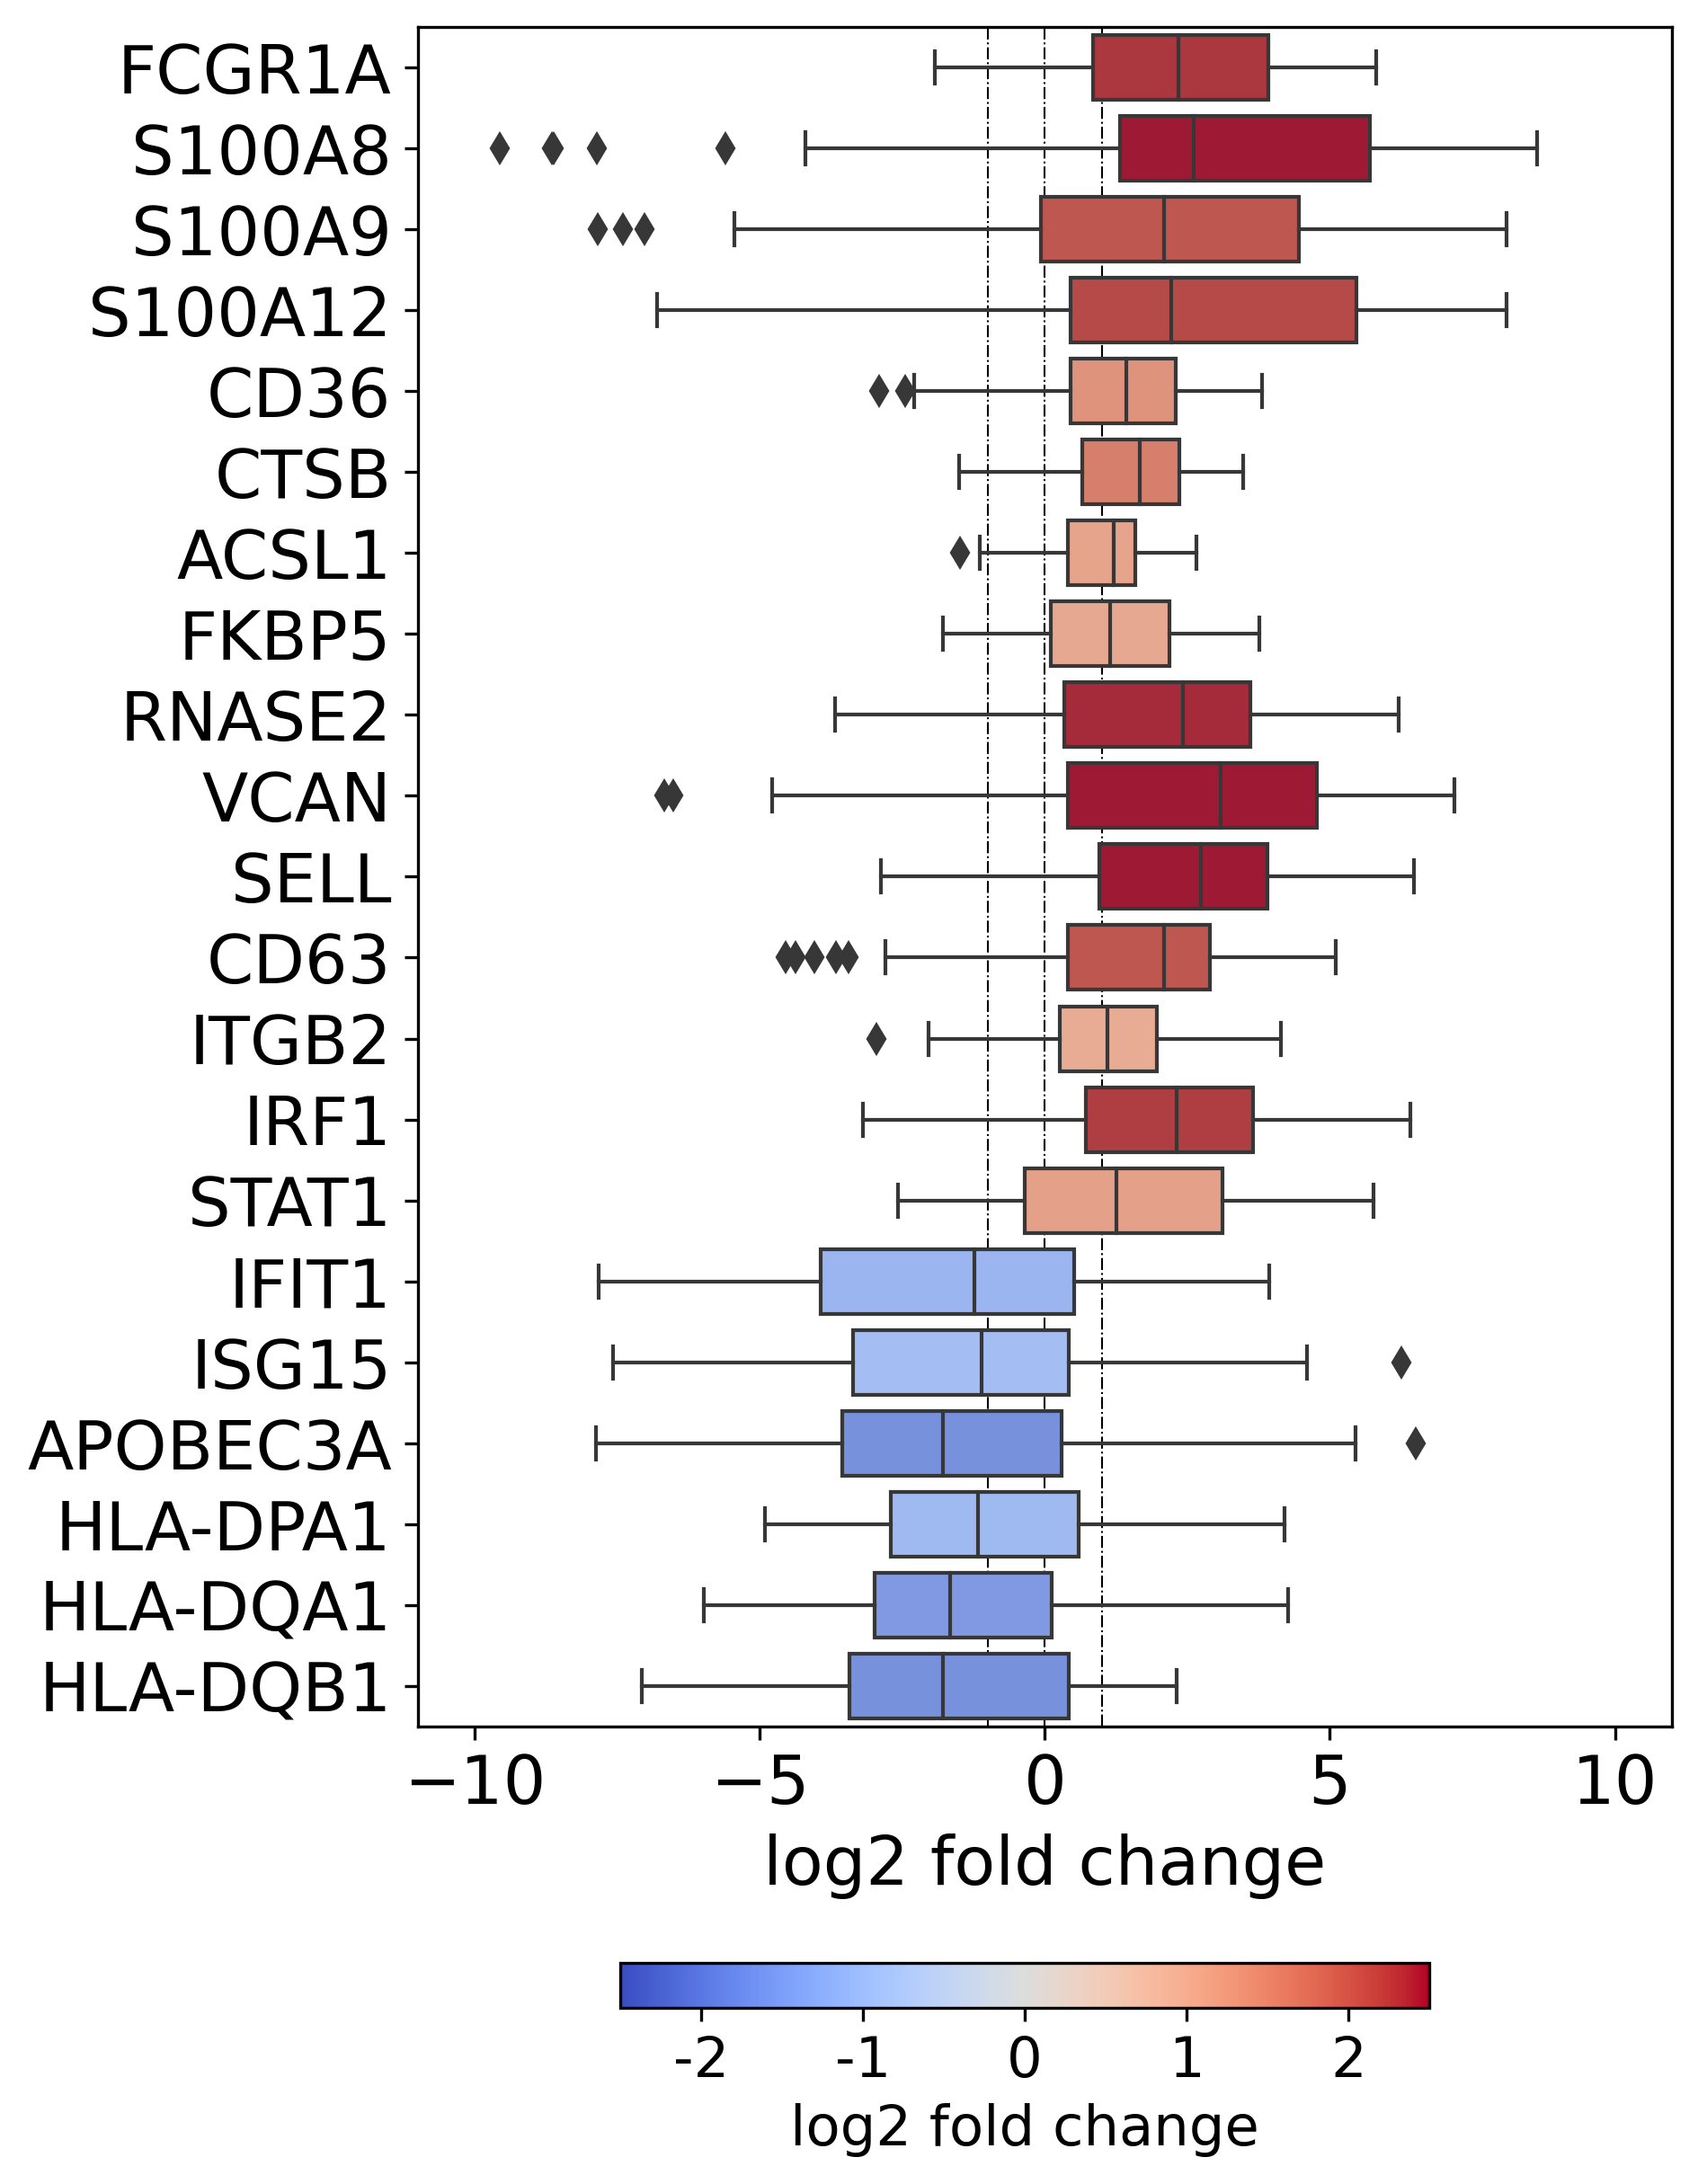

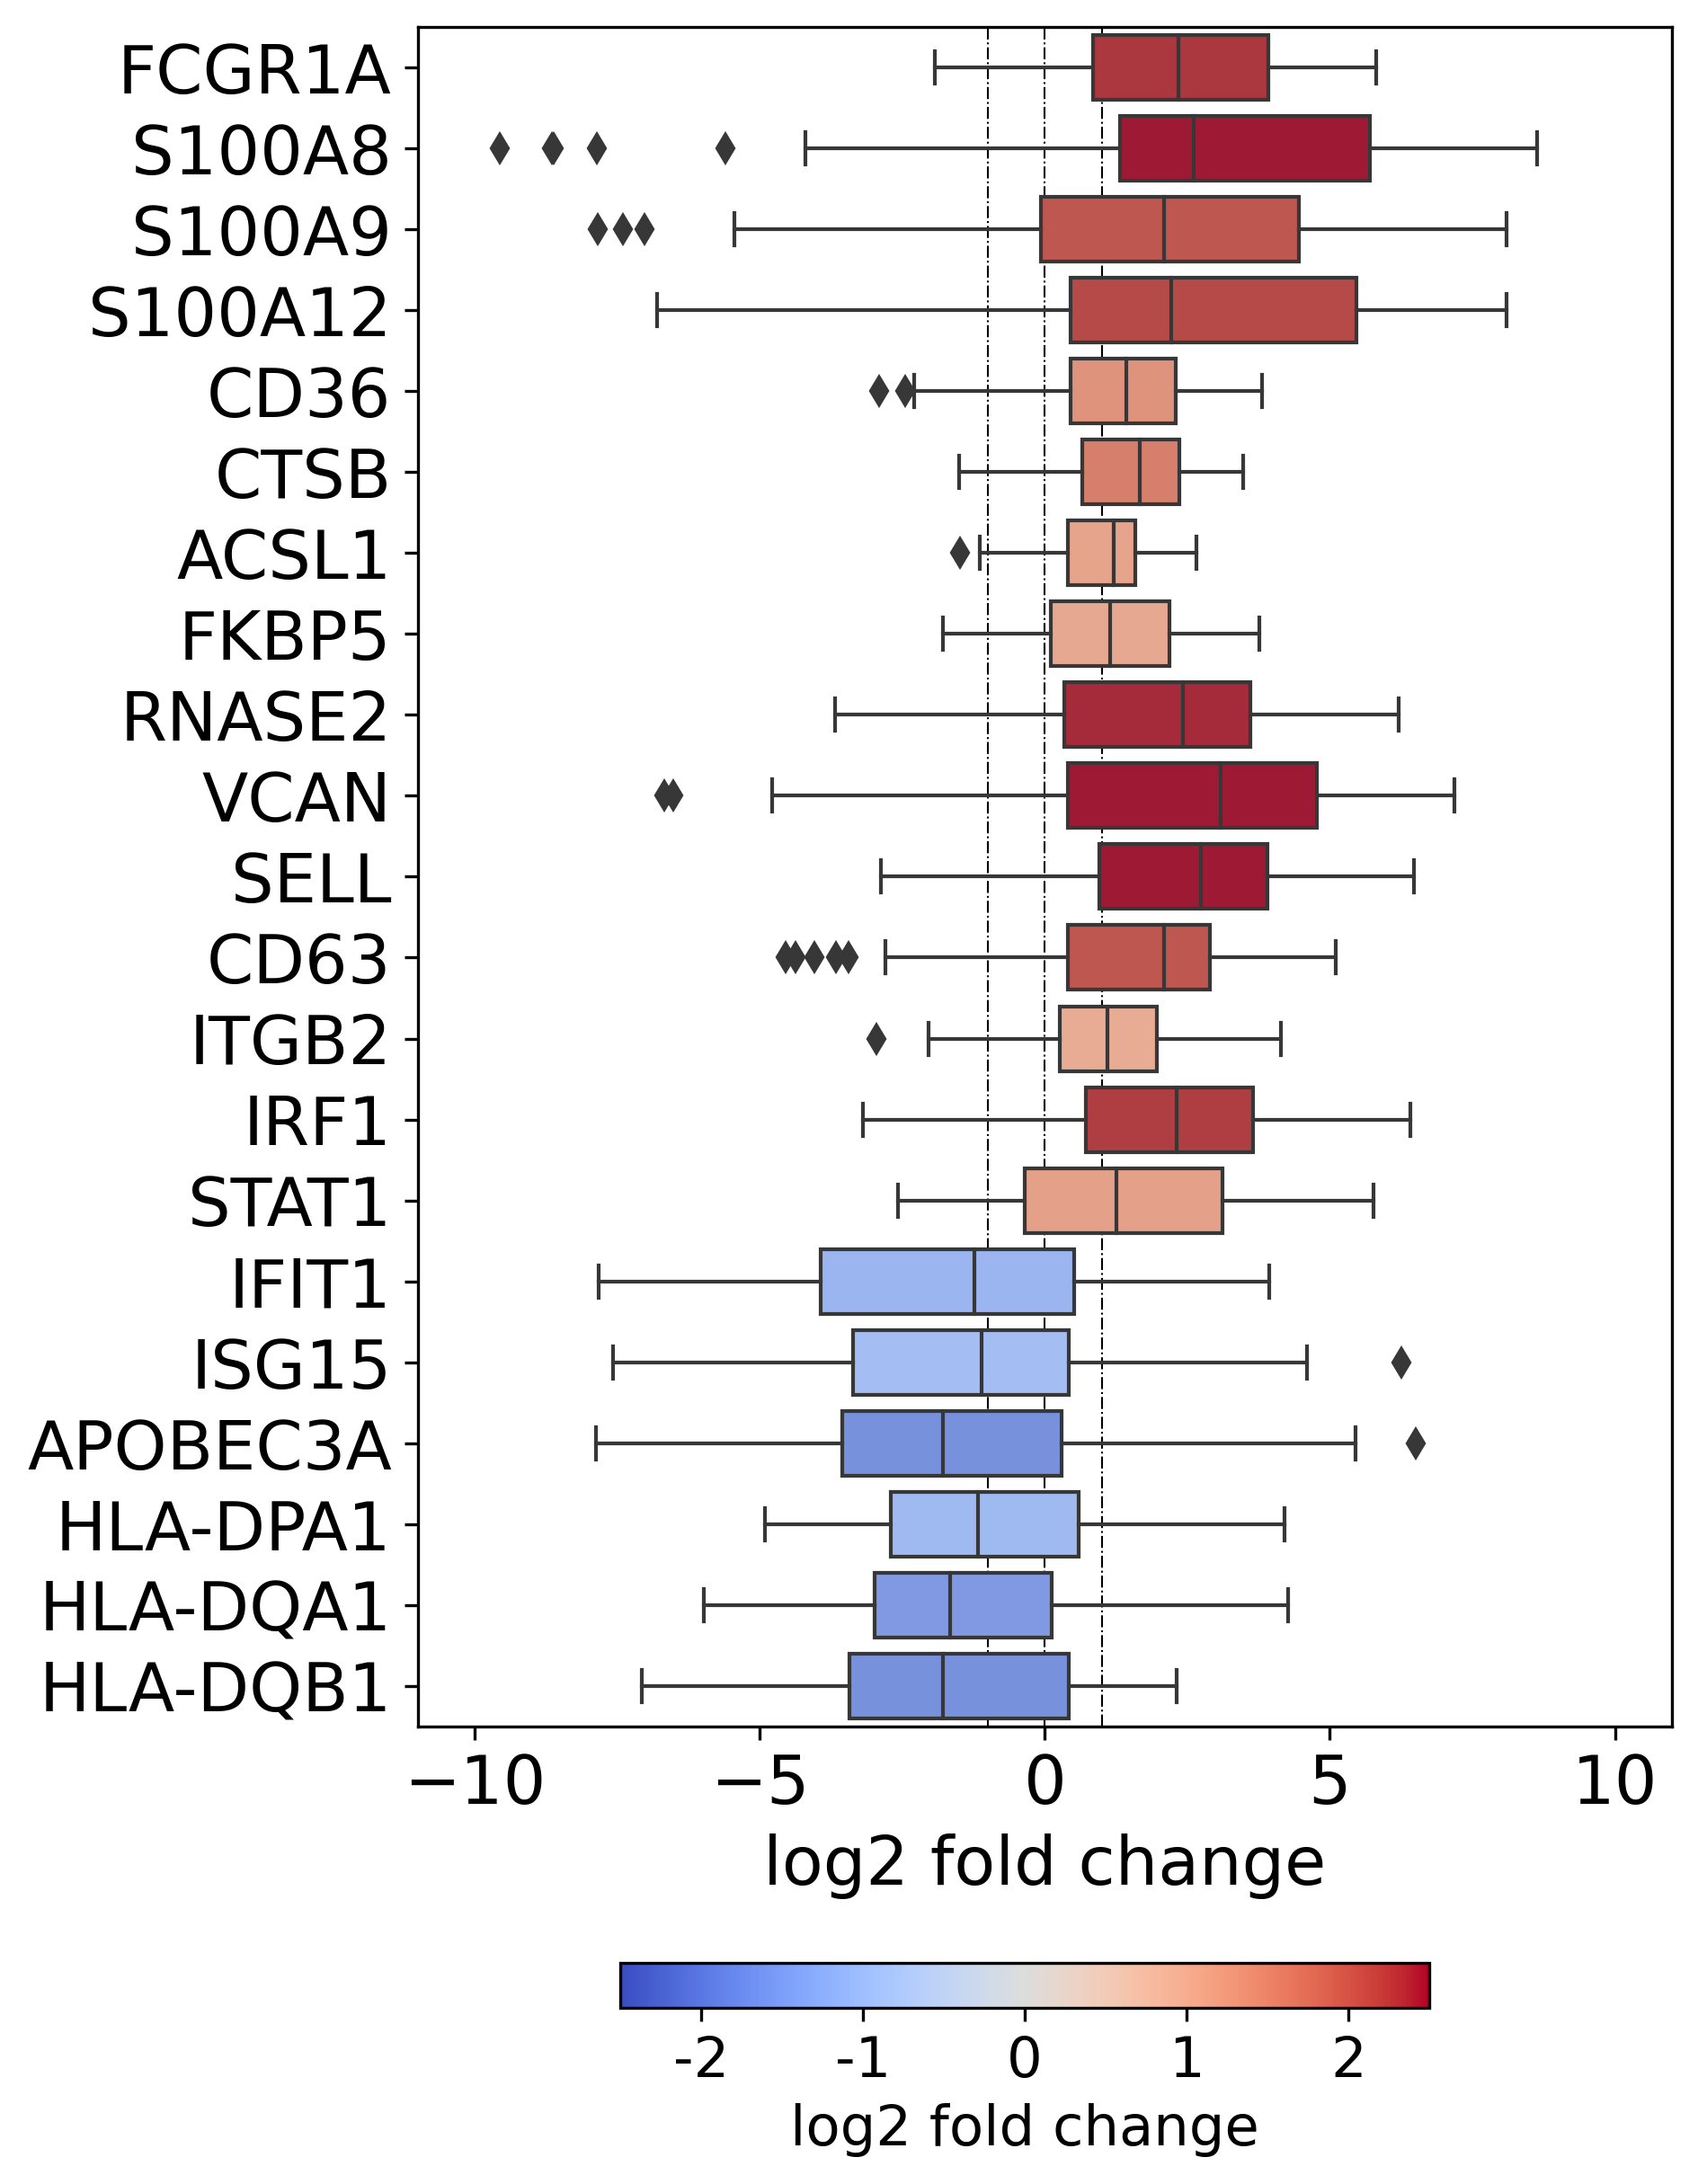

In [38]:
mo_genes = [
            'FCGR1A', 'S100A8', 'S100A9', 'S100A12', 'CD36', 'CTSB', 'ACSL1','FKBP5', 'RNASE2', 
            'VCAN', 'SELL', 'CD63', 'ITGB2',
            'IRF1', 'STAT1',
            'IFIT1', 'ISG15', 'APOBEC3A',
            'HLA-DPA1', 'HLA-DQA1', 'HLA-DQB1'   
]
pairwise_boxplot(ct_log2FC, ['Monocytes'], mo_genes, path='box_mo_genes.pdf')
pairwise_boxplot(ct_log2FC, ['Monocytes'], mo_genes, path='box_mo_genes.png')

{'figure': <Figure size 1650x4500 with 2 Axes>, 'ax': <AxesSubplot:>}

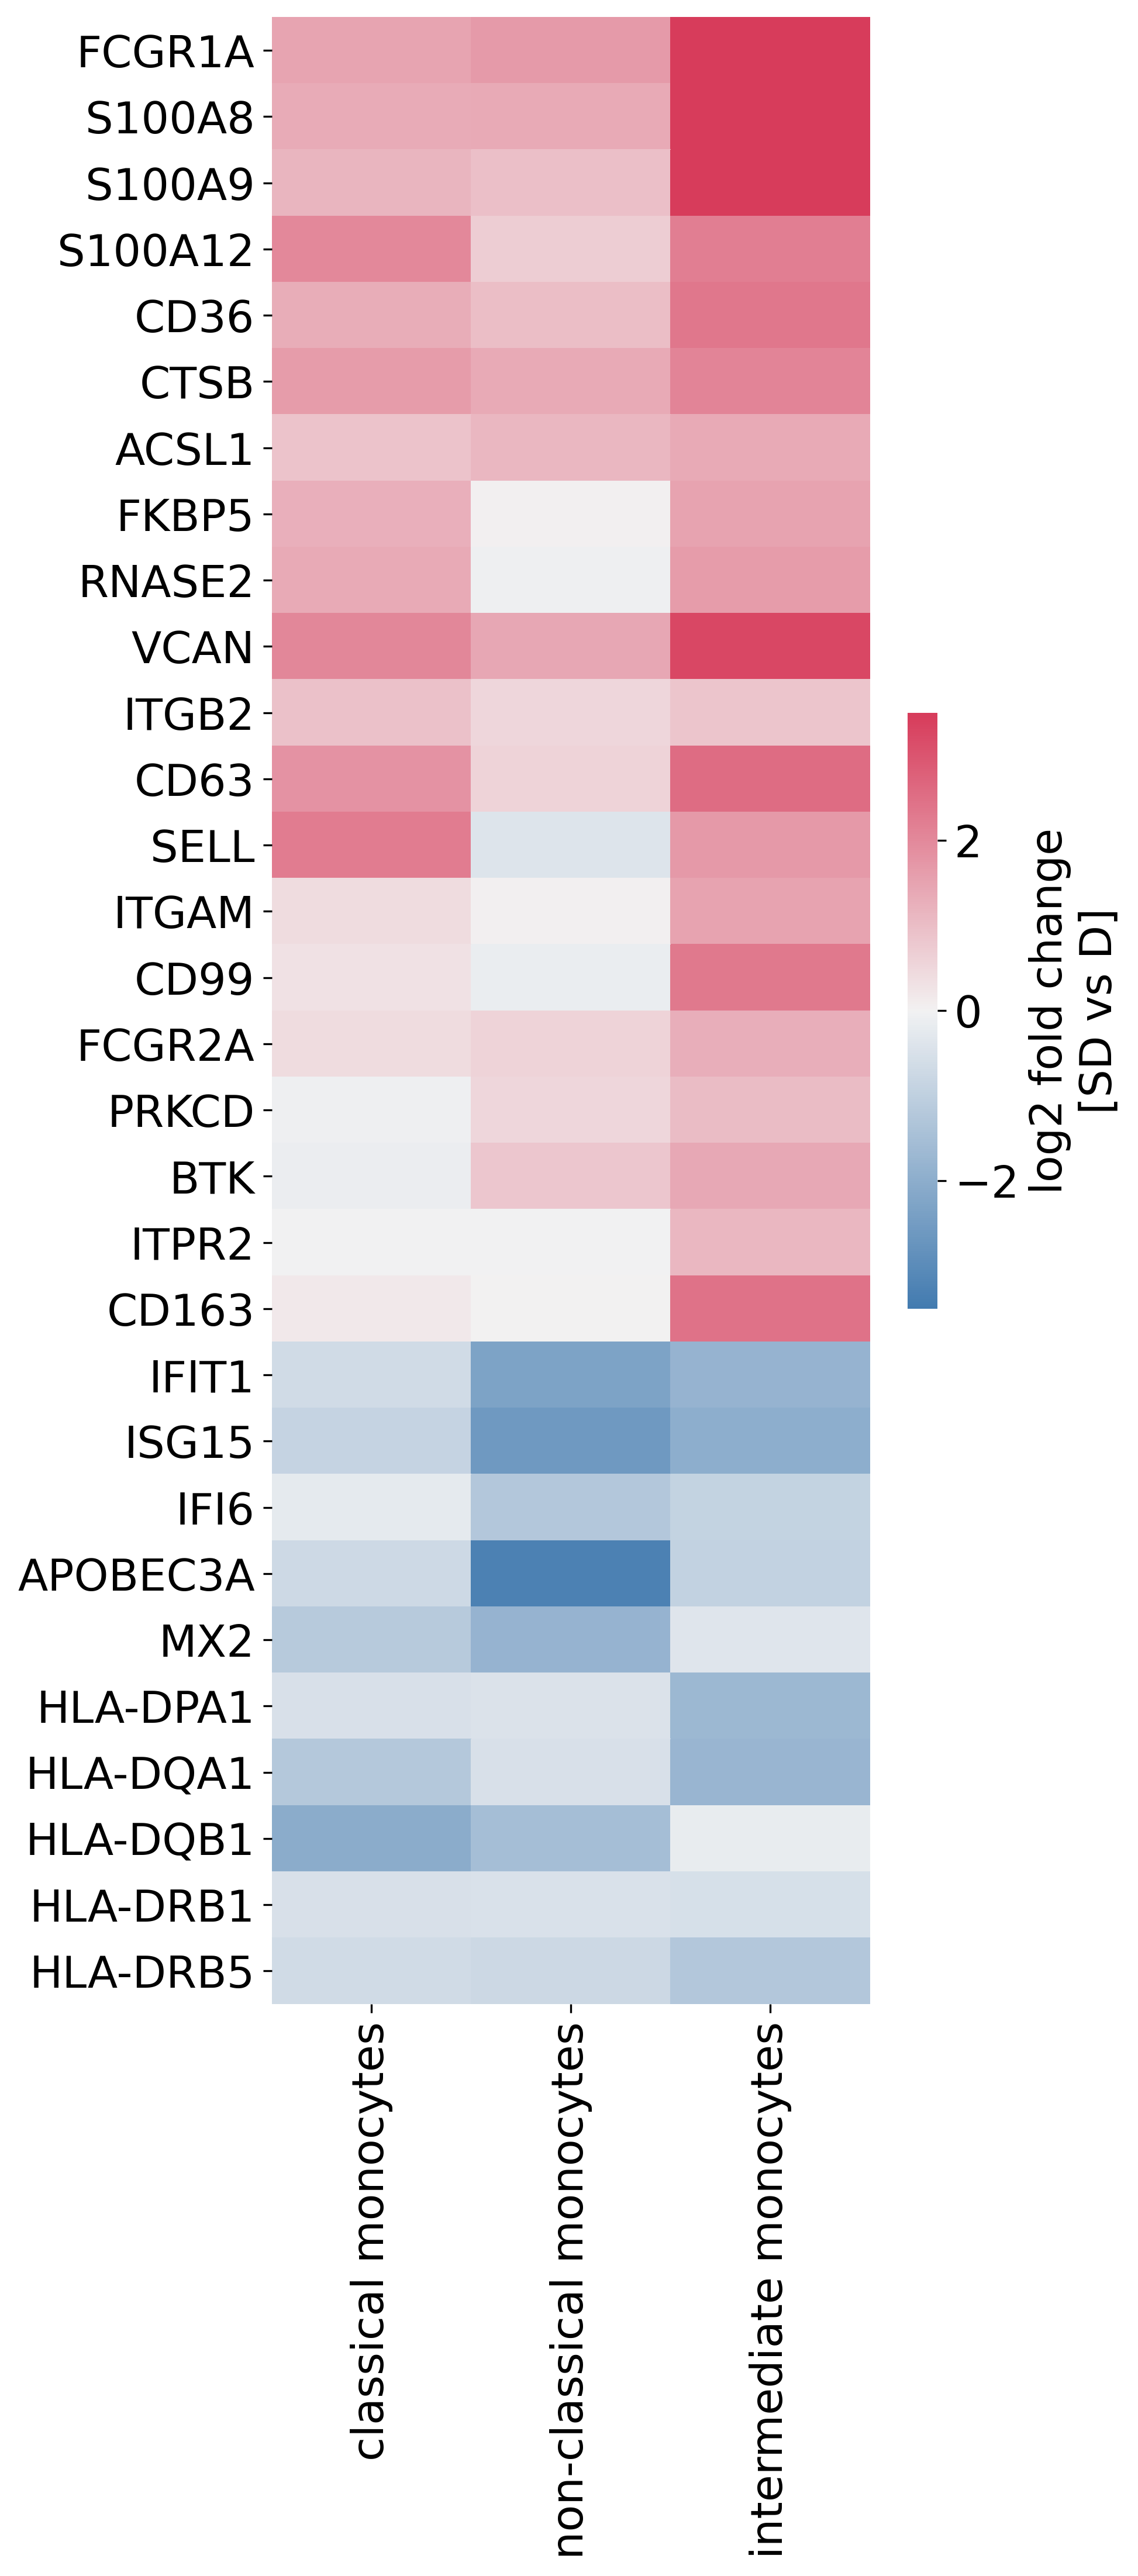

In [36]:
glist = [
       'FCGR1A', 'S100A8', 'S100A9', 'S100A12', 'CD36', 'CTSB', 'ACSL1', 'FKBP5', 'RNASE2',
       'VCAN', 'ITGB2', 'CD63', 'SELL', 'ITGAM', 'CD99',
       'FCGR2A', 'PRKCD', 'BTK', 'ITPR2', 'CD163',
       # 'IRF1', 'STAT1',
       'IFIT1', 'ISG15', 'IFI6', 'APOBEC3A', 'MX2', #'RSAD2', 'IFIT3', 'MX1', 
       'HLA-DPA1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1', 'HLA-DRB5',#'HLA-DMA','HLA-DMB', 'HLA-DPB1', 'HLA-DRA', 
    
]
heatmap_cst(cst_pair, glist, ['classical monocytes', 'non-classical monocytes', 'intermediate monocytes', ], 
            save_fd='mo_cst_heatmap.pdf')
heatmap_cst(cst_pair, glist, ['classical monocytes', 'non-classical monocytes', 'intermediate monocytes'], 
            save_fd='mo_cst_heatmap.png')

{'figure': <Figure size 1800x3135 with 2 Axes>,
 'ax': <AxesSubplot:xlabel='log2 fold change'>}

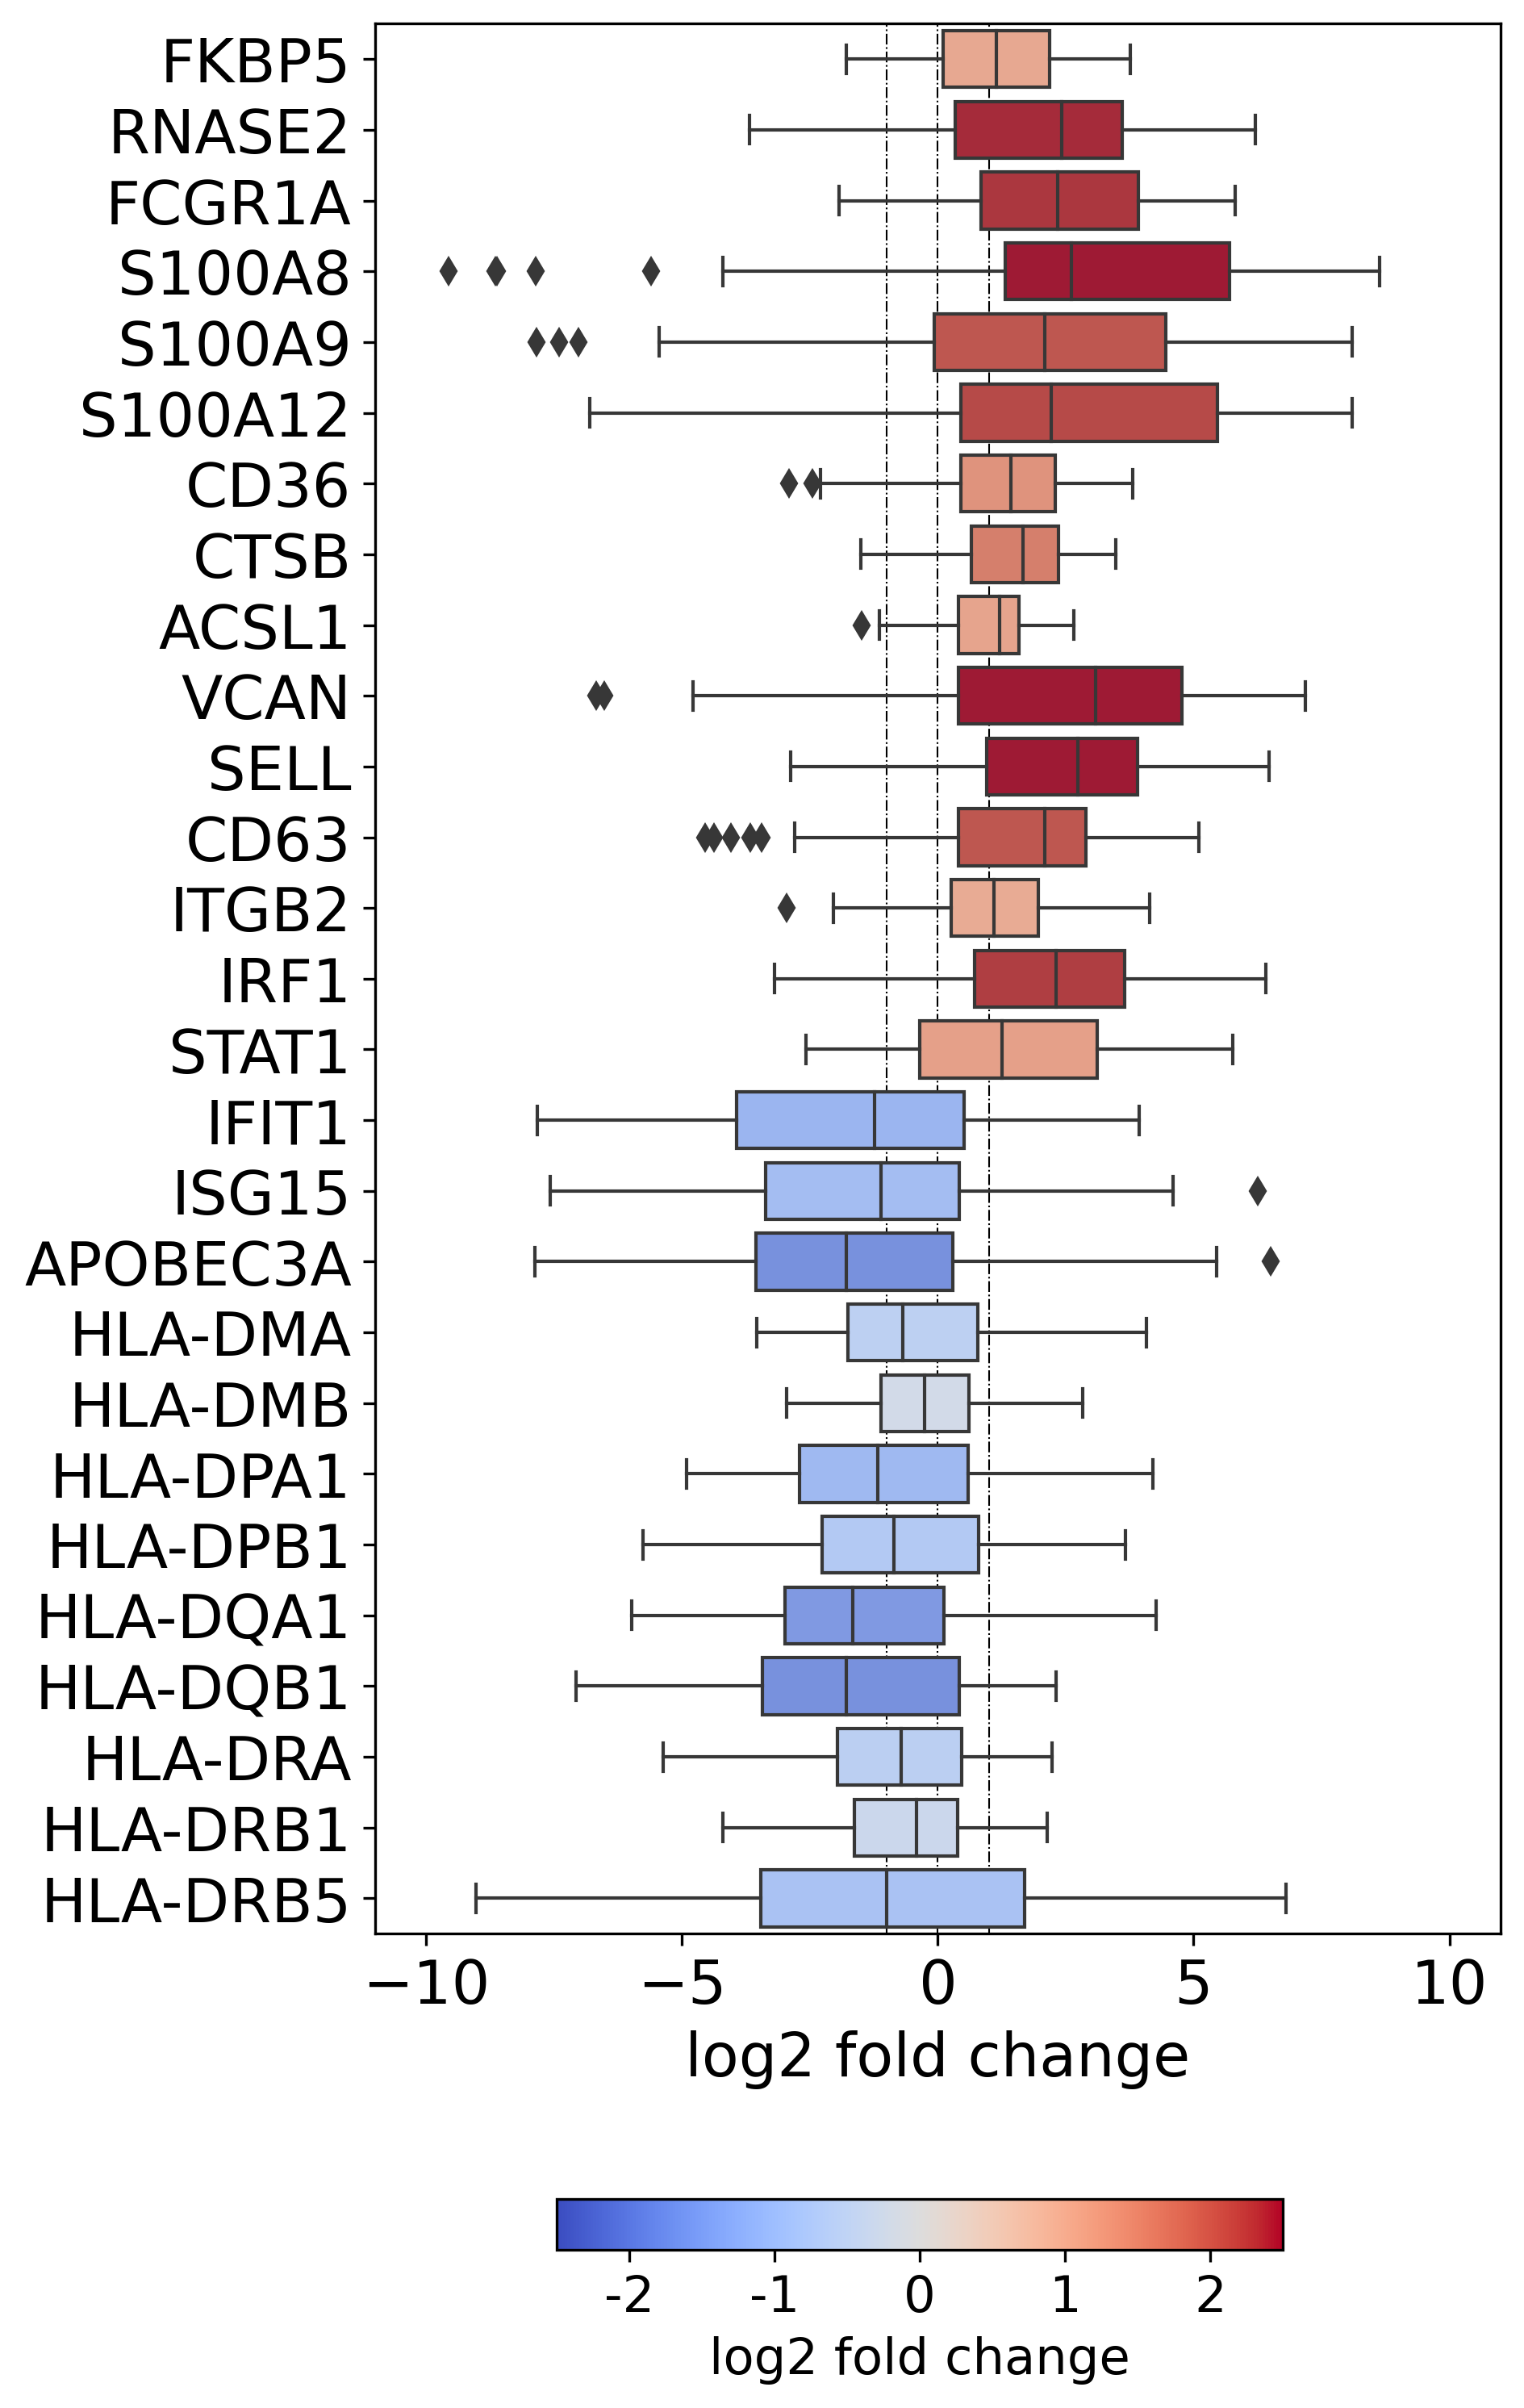

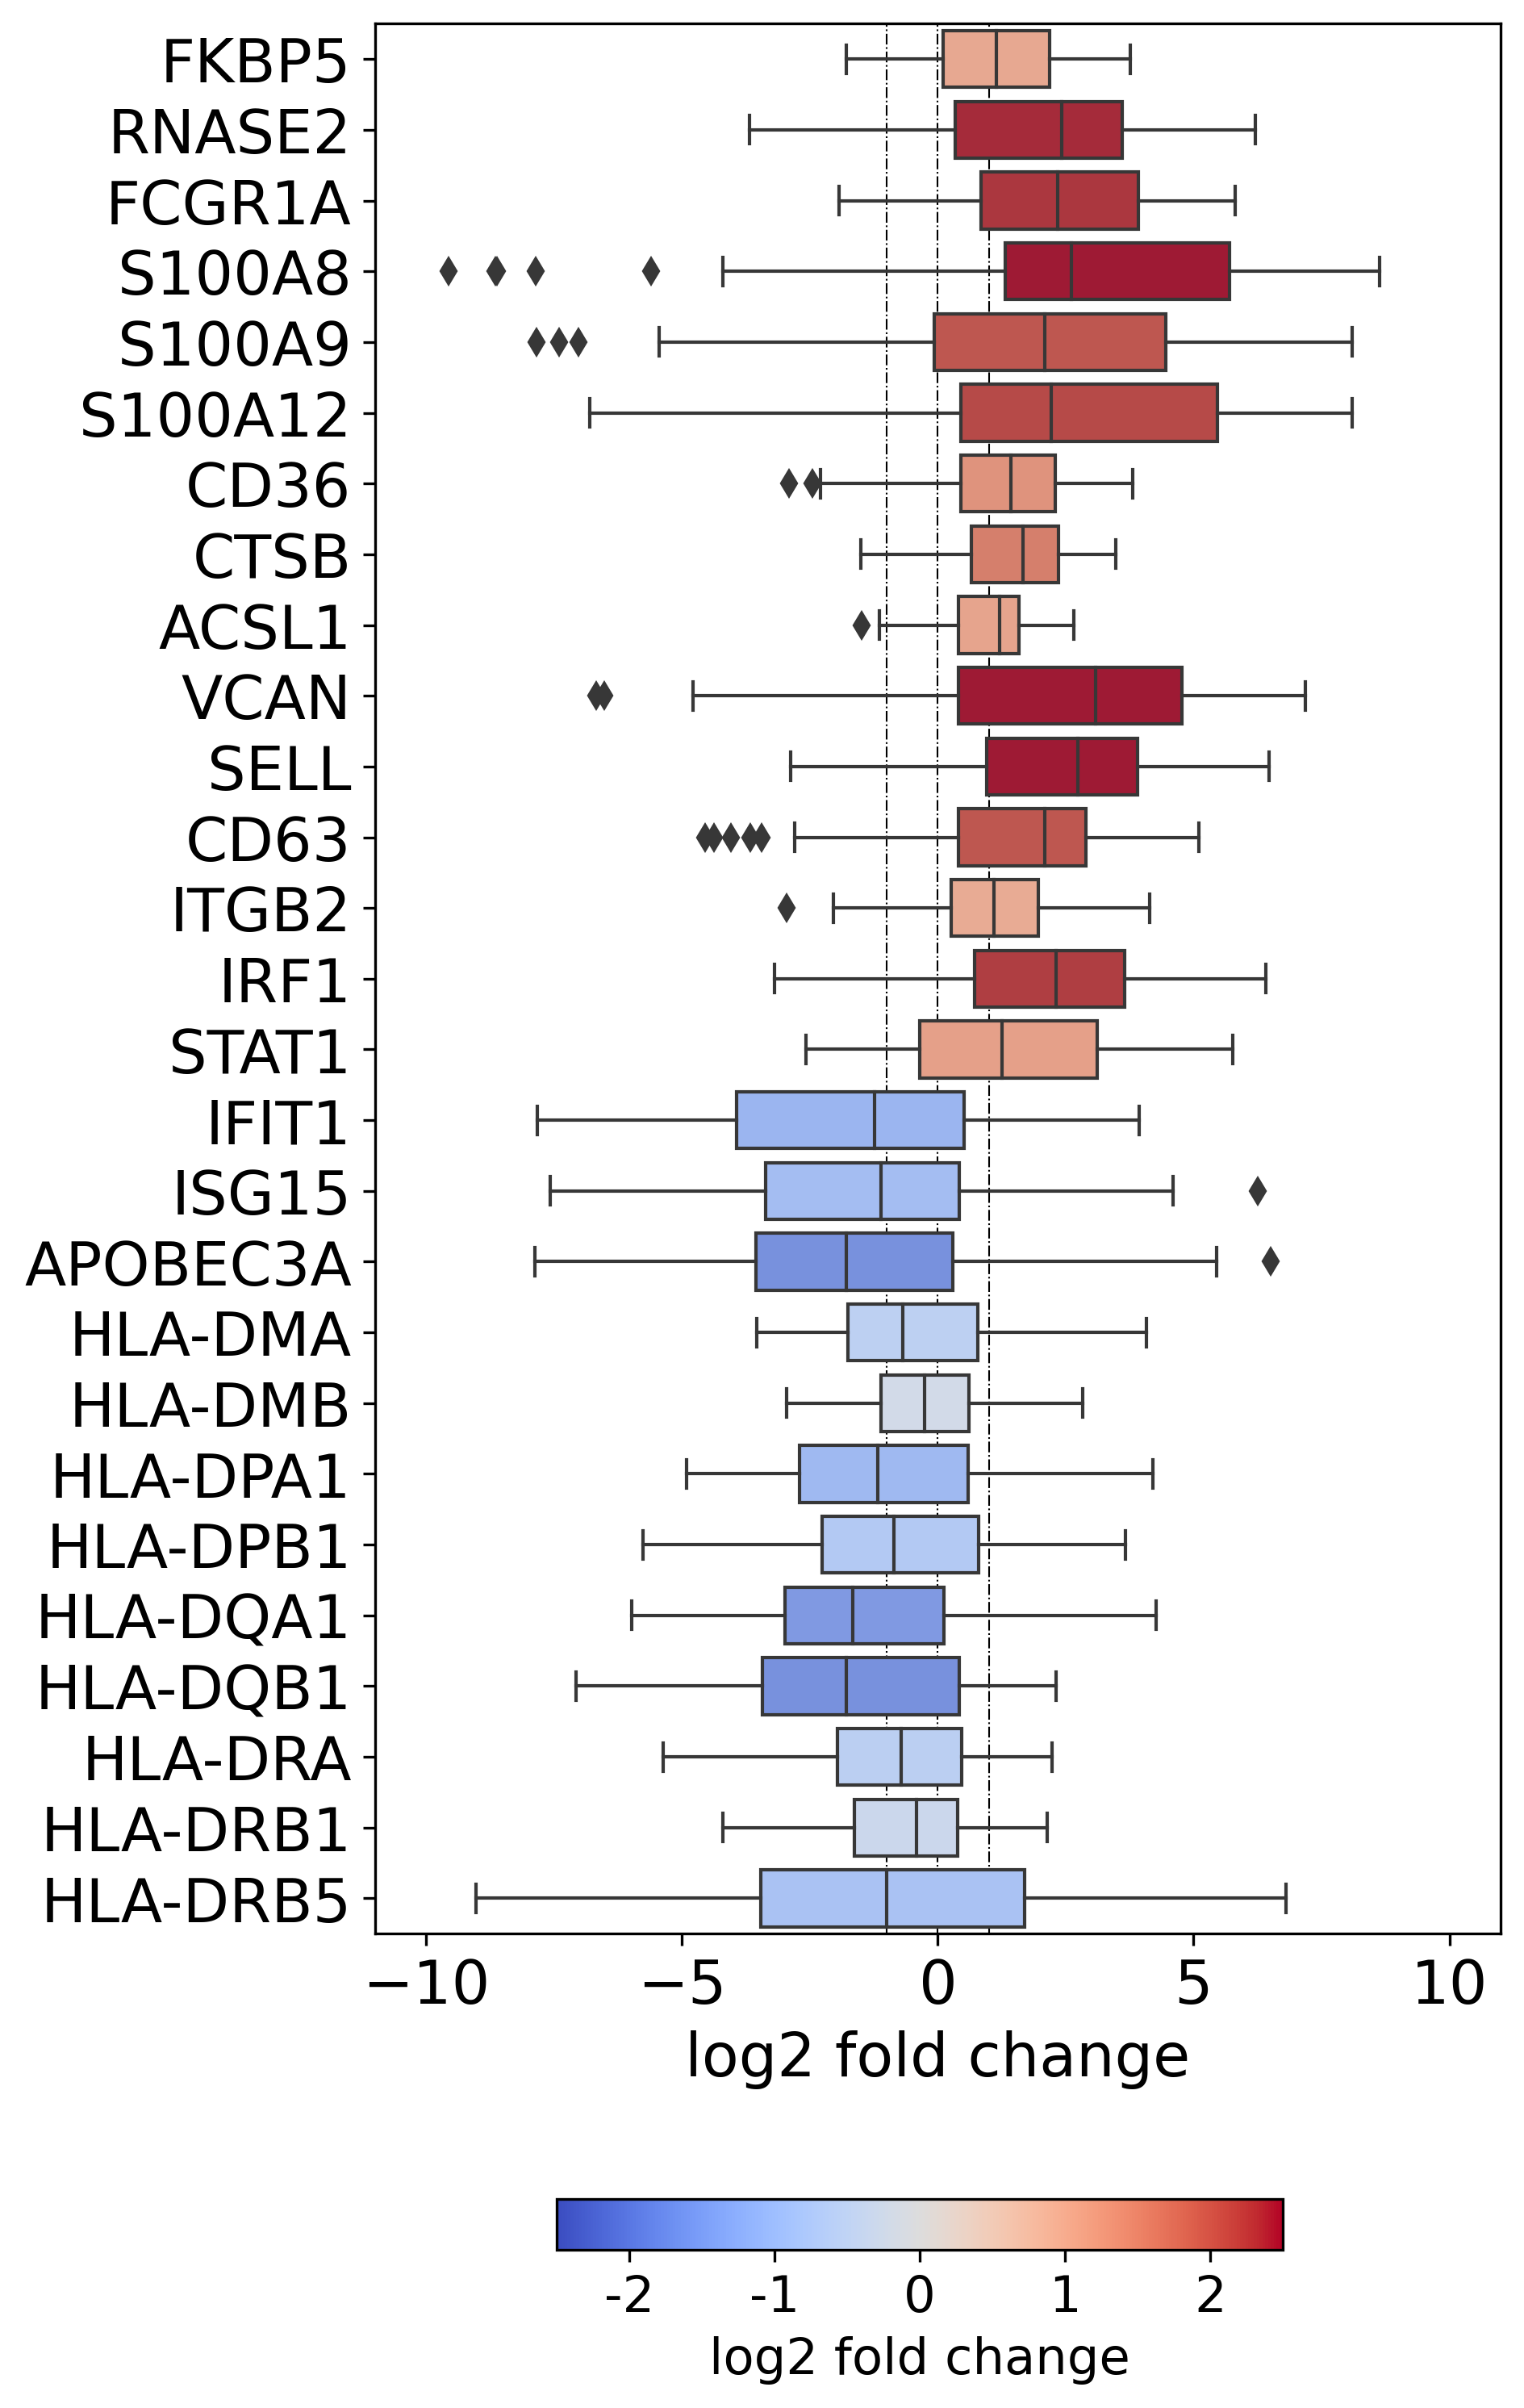

In [39]:
child_genes = [
'FKBP5', 'RNASE2',
            'FCGR1A', 'S100A8', 'S100A9', 'S100A12', 'CD36', 'CTSB', 'ACSL1',
            'VCAN', 'SELL', 'CD63', 'ITGB2',
            'IRF1', 'STAT1',
            'IFIT1', 'ISG15', 'APOBEC3A',
            'HLA-DMA','HLA-DMB', 'HLA-DPA1', 'HLA-DPB1','HLA-DQA1', 'HLA-DQB1','HLA-DRA', 'HLA-DRB1', 'HLA-DRB5'
]
pairwise_boxplot(ct_log2FC, ['Monocytes'], child_genes, path='mo_child.pdf')
pairwise_boxplot(ct_log2FC, ['Monocytes'], child_genes, path='mo_child.png')

{'figure': <Figure size 1800x1560 with 2 Axes>,
 'ax': <AxesSubplot:xlabel='log2 fold change'>}

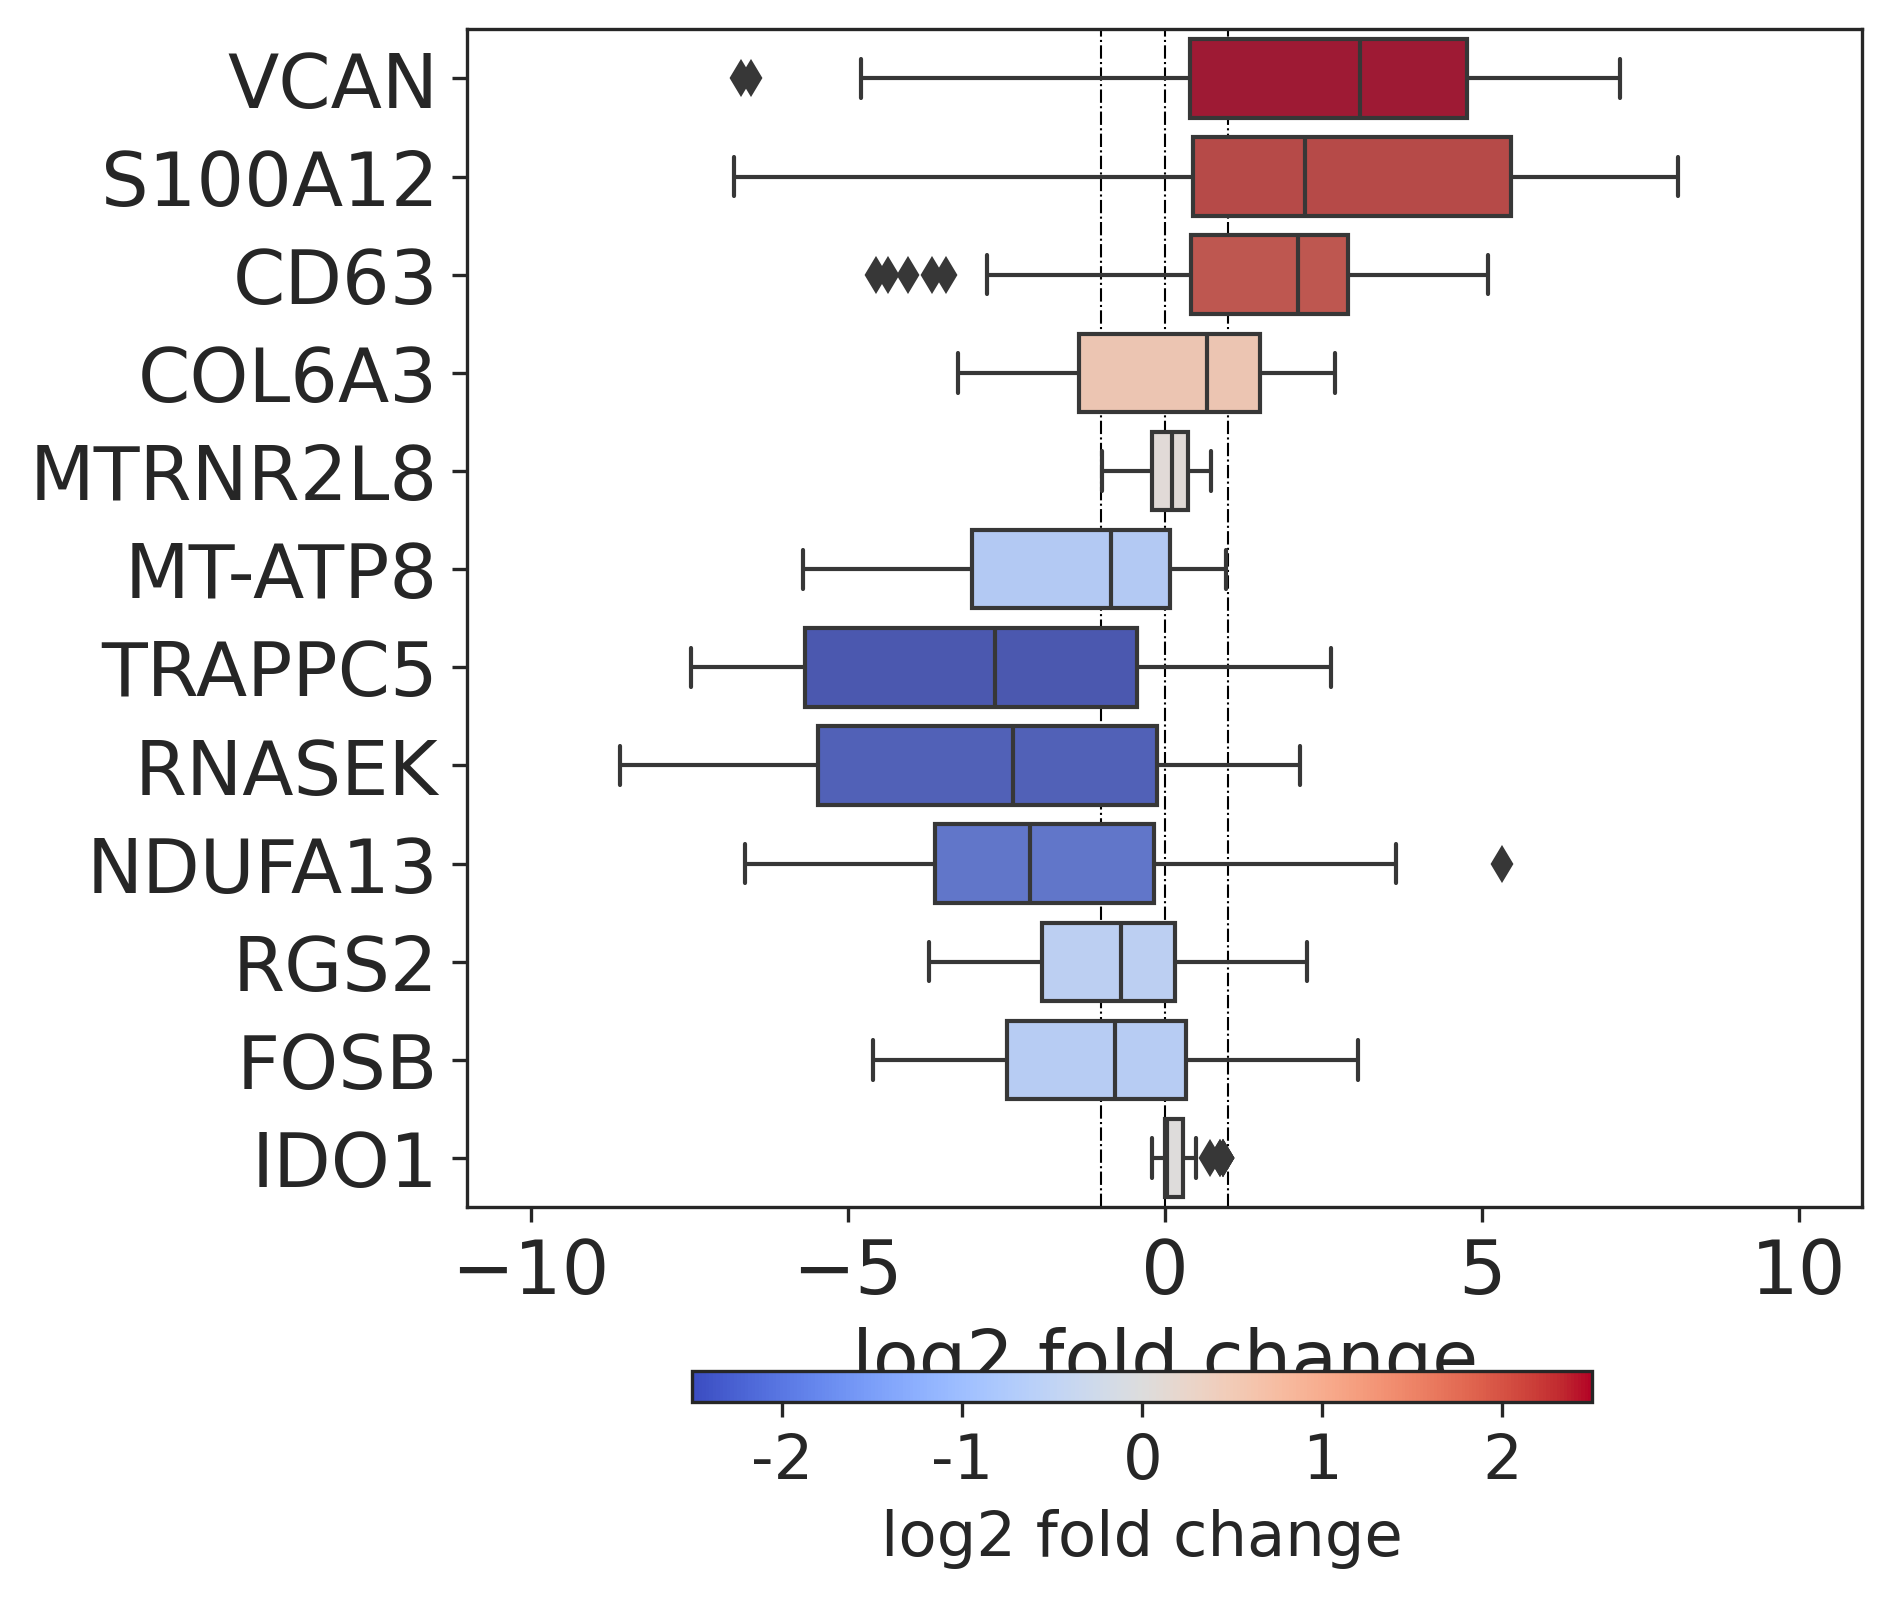

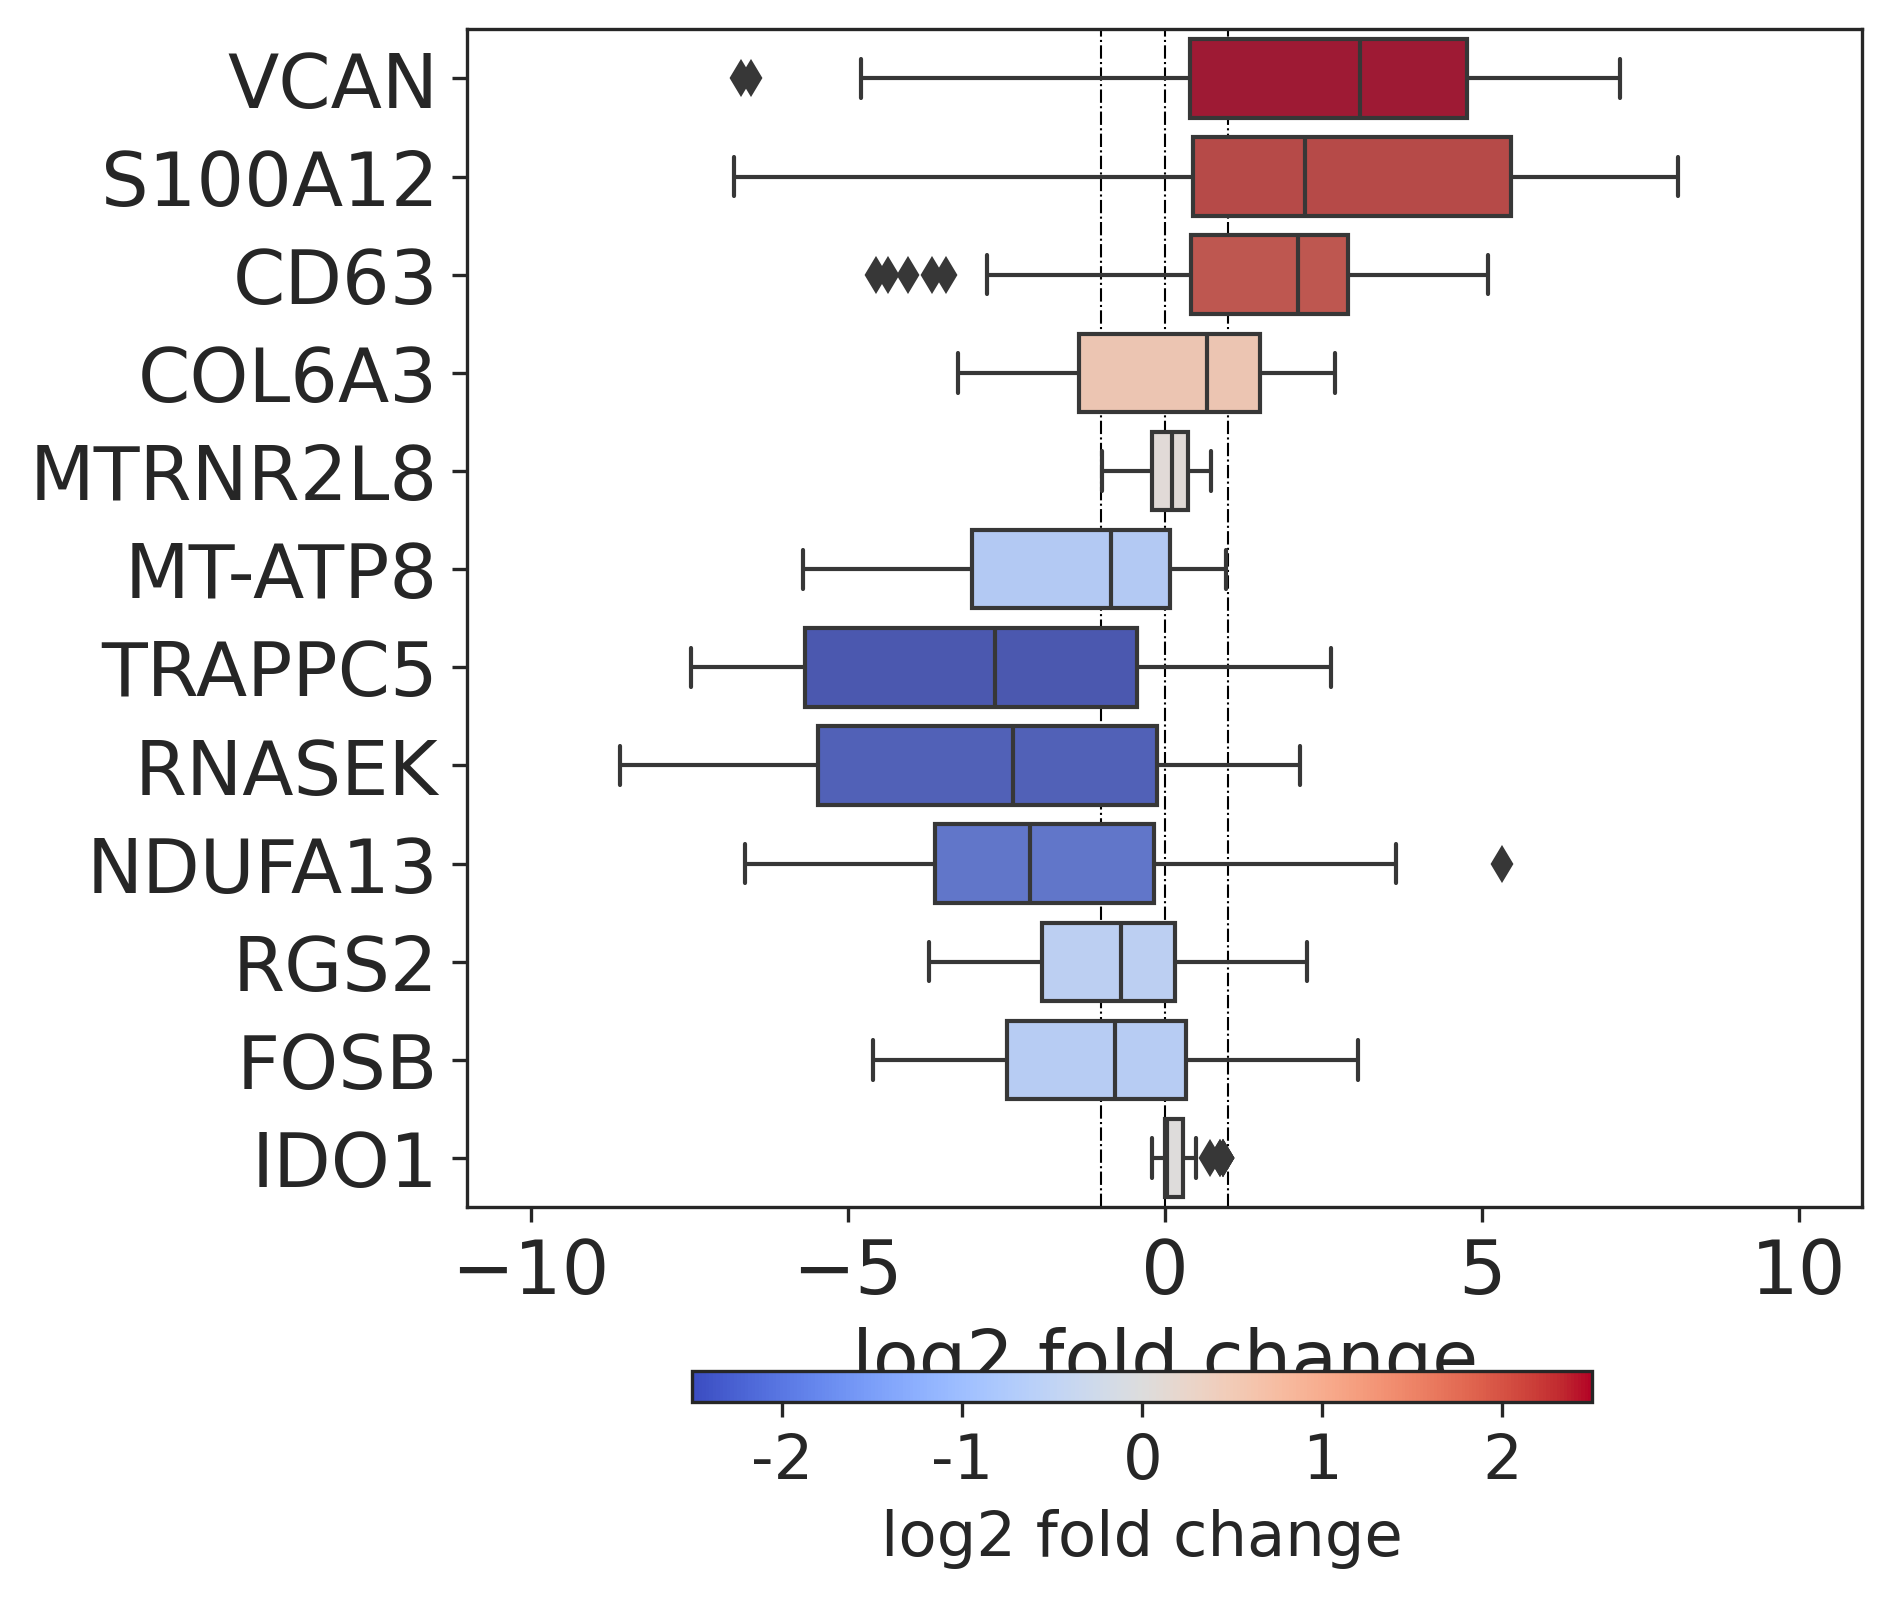

In [192]:
child_genes = ['VCAN', 'S100A12', 'CD63', 
             'COL6A3', 'MTRNR2L8', 'MT-ATP8', 
             'TRAPPC5', 'RNASEK', 'NDUFA13', 
             'RGS2', 'FOSB', 'IDO1']



pairwise_boxplot(ct_log2FC, ['Monocytes'], child_genes, path='mo_child_sup.pdf')
pairwise_boxplot(ct_log2FC, ['Monocytes'], child_genes, path='mo_child_sup.png')

{'figure': <Figure size 1800x3135 with 2 Axes>,
 'ax': <AxesSubplot:xlabel='log2 fold change'>}

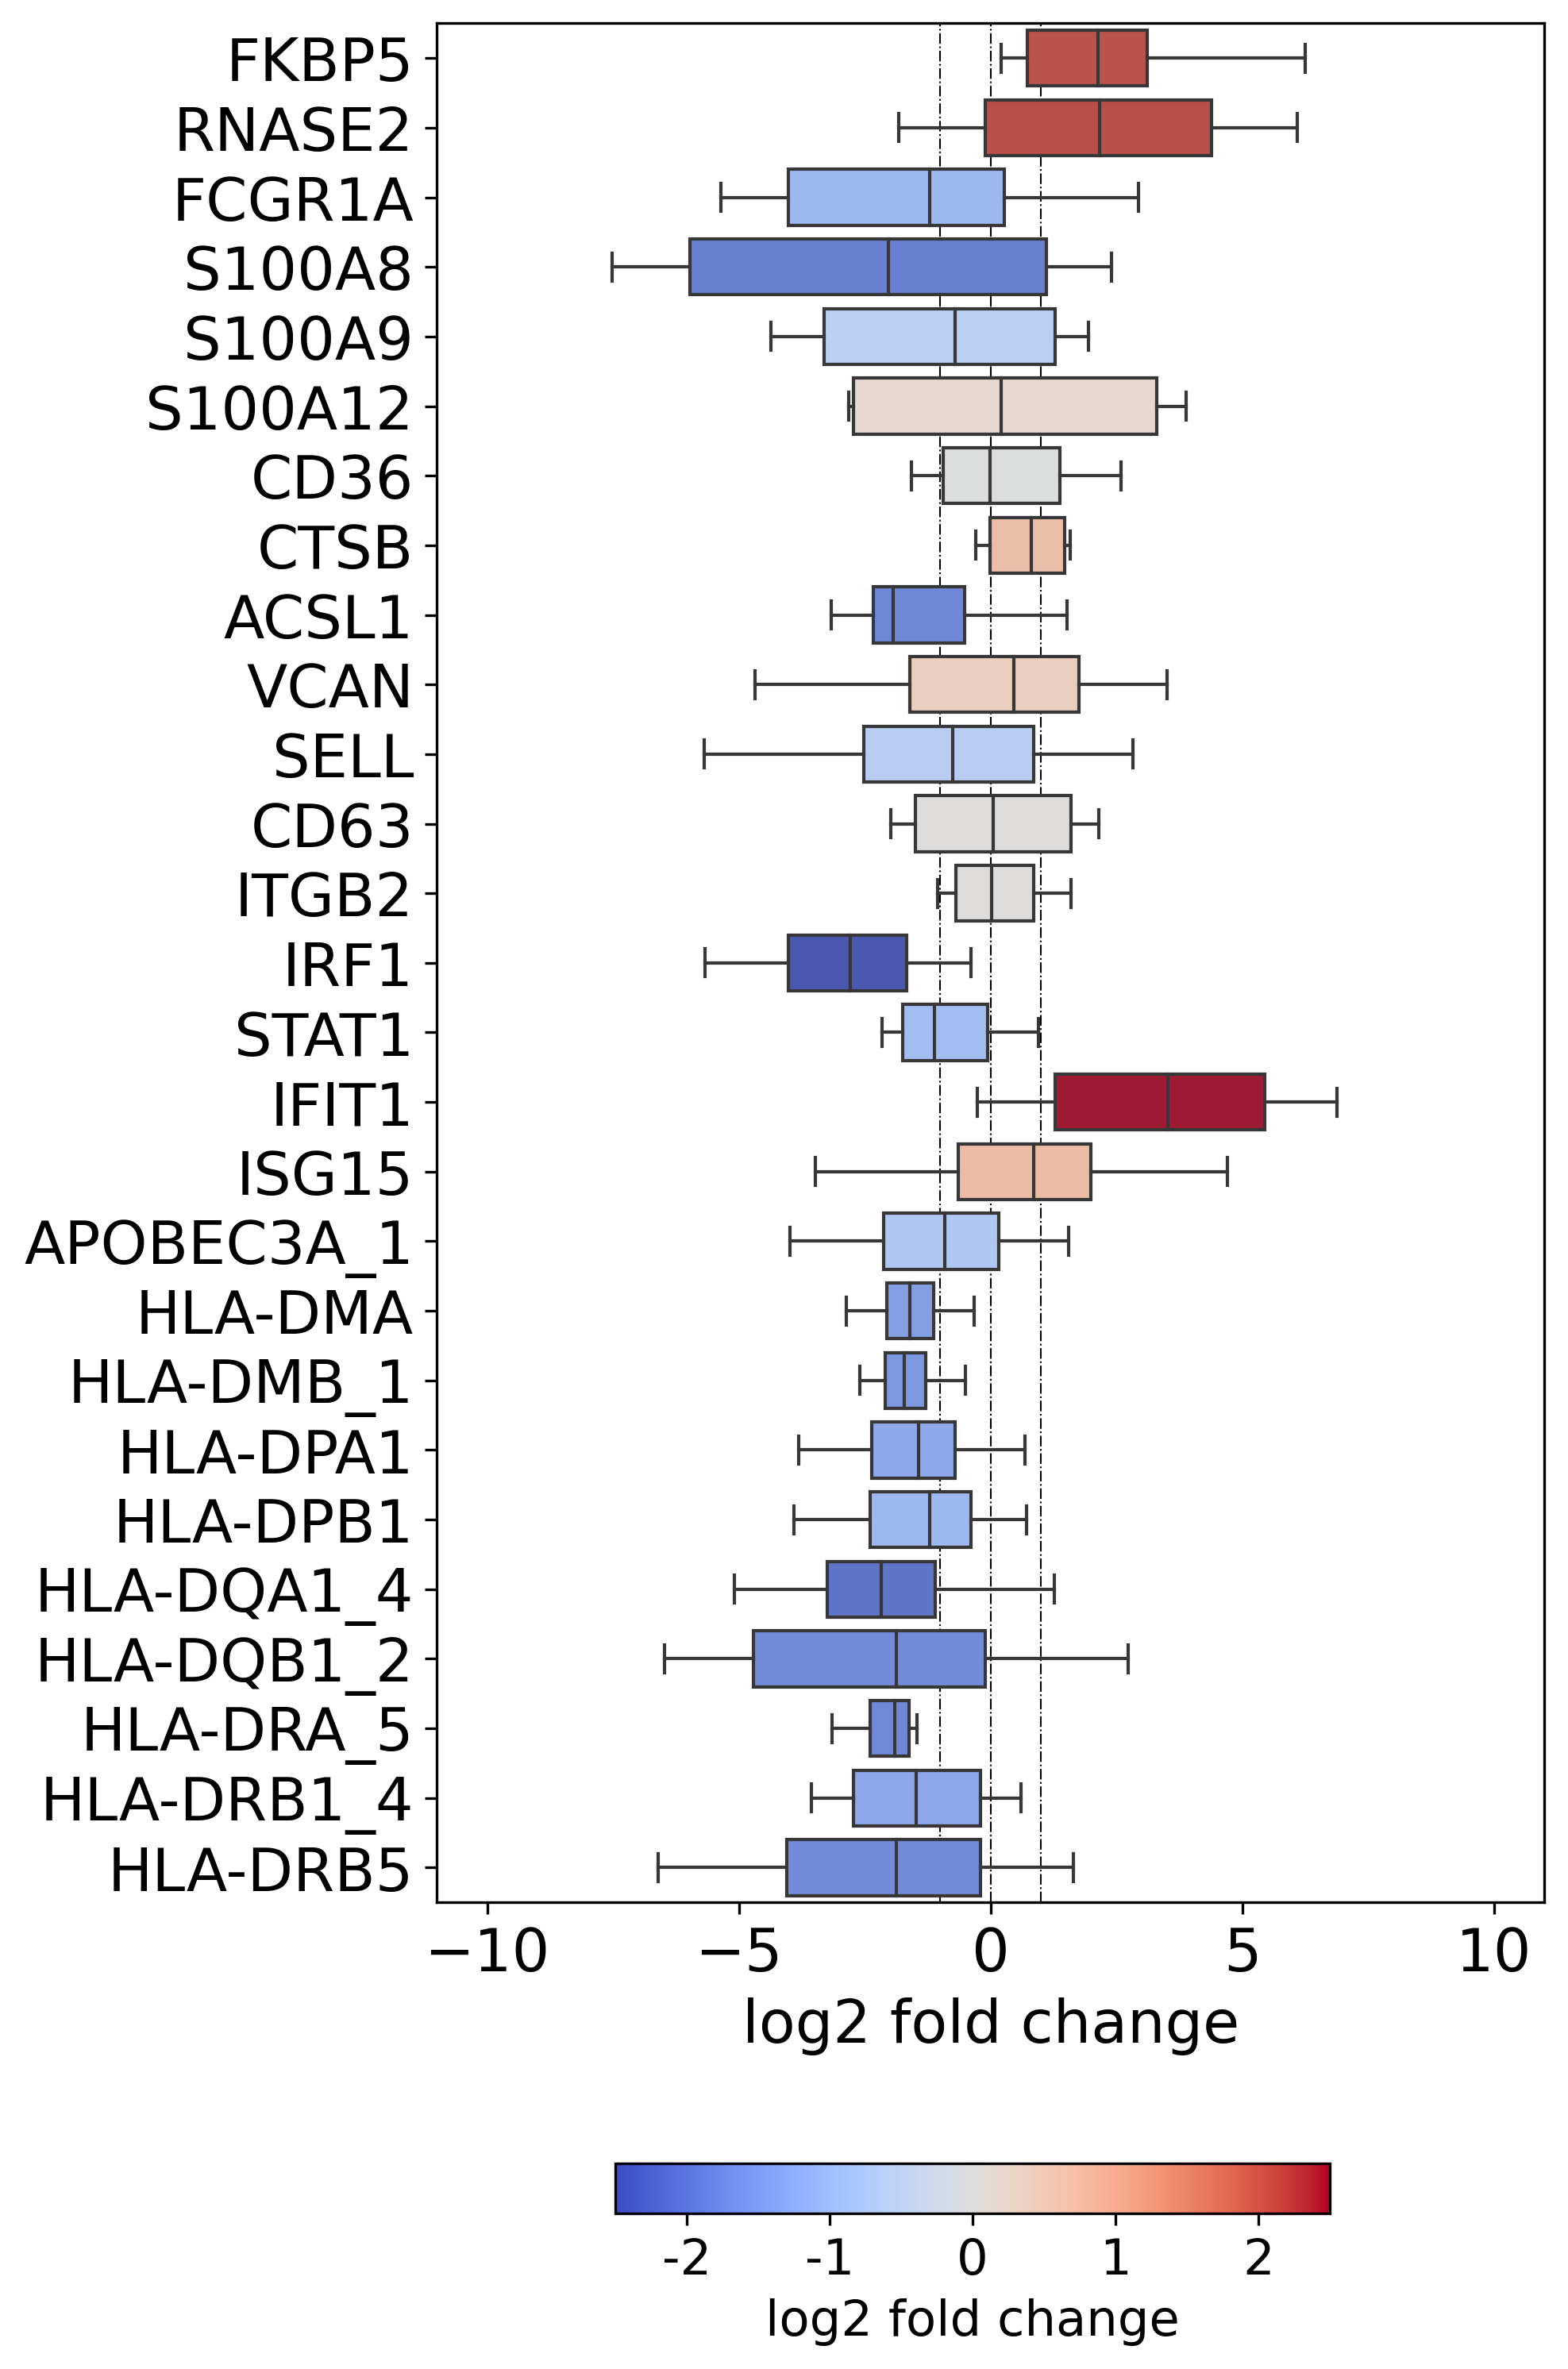

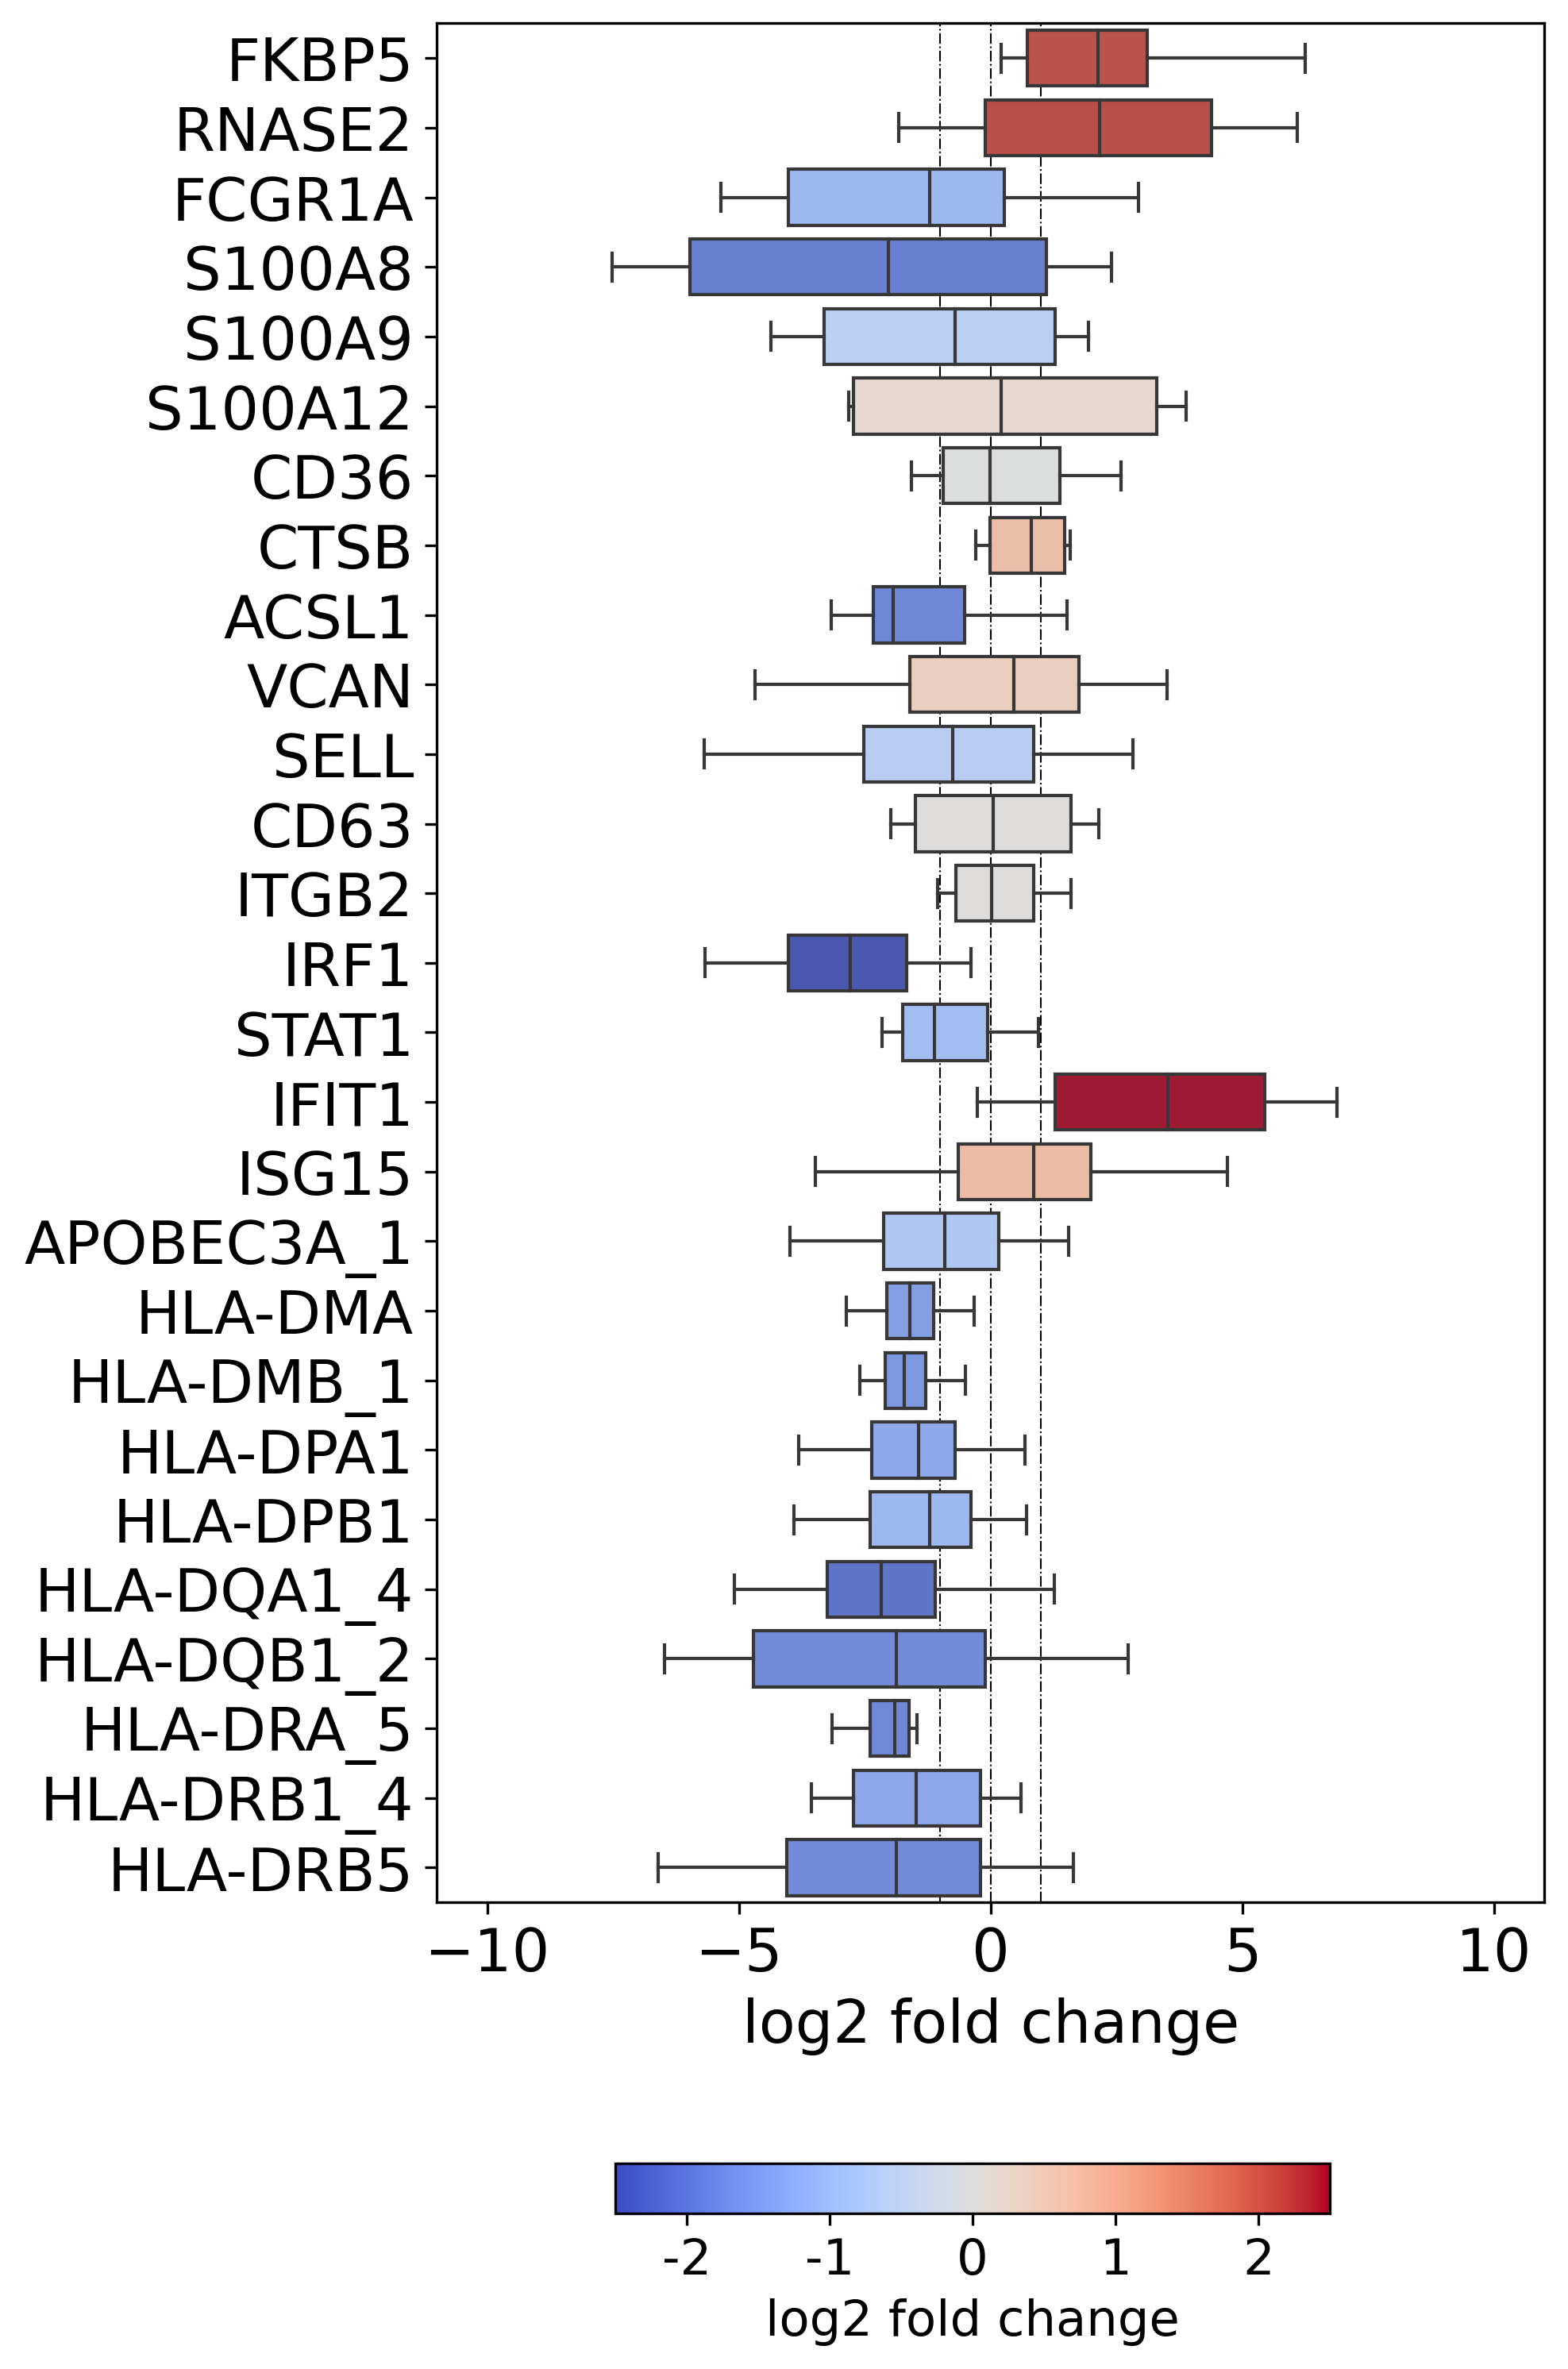

In [40]:
adult_genes = [
    'FKBP5', 'RNASE2',
            'FCGR1A', 'S100A8', 'S100A9', 'S100A12', 'CD36', 'CTSB', 'ACSL1',
            'VCAN', 'SELL', 'CD63', 'ITGB2',
            'IRF1', 'STAT1',
            'IFIT1', 'ISG15', 'APOBEC3A_1',
            'HLA-DMA','HLA-DMB_1',  'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1_4', 'HLA-DQB1_2', 'HLA-DRA_5', 'HLA-DRB1_4', 'HLA-DRB5',
]
 
pairwise_boxplot(ct_log2FC_a, ['Monocytes'], adult_genes, path='mo_adult.pdf')
pairwise_boxplot(ct_log2FC_a, ['Monocytes'], adult_genes, path='mo_adult.png')

{'figure': <Figure size 1800x1560 with 2 Axes>,
 'ax': <AxesSubplot:xlabel='log2 fold change'>}

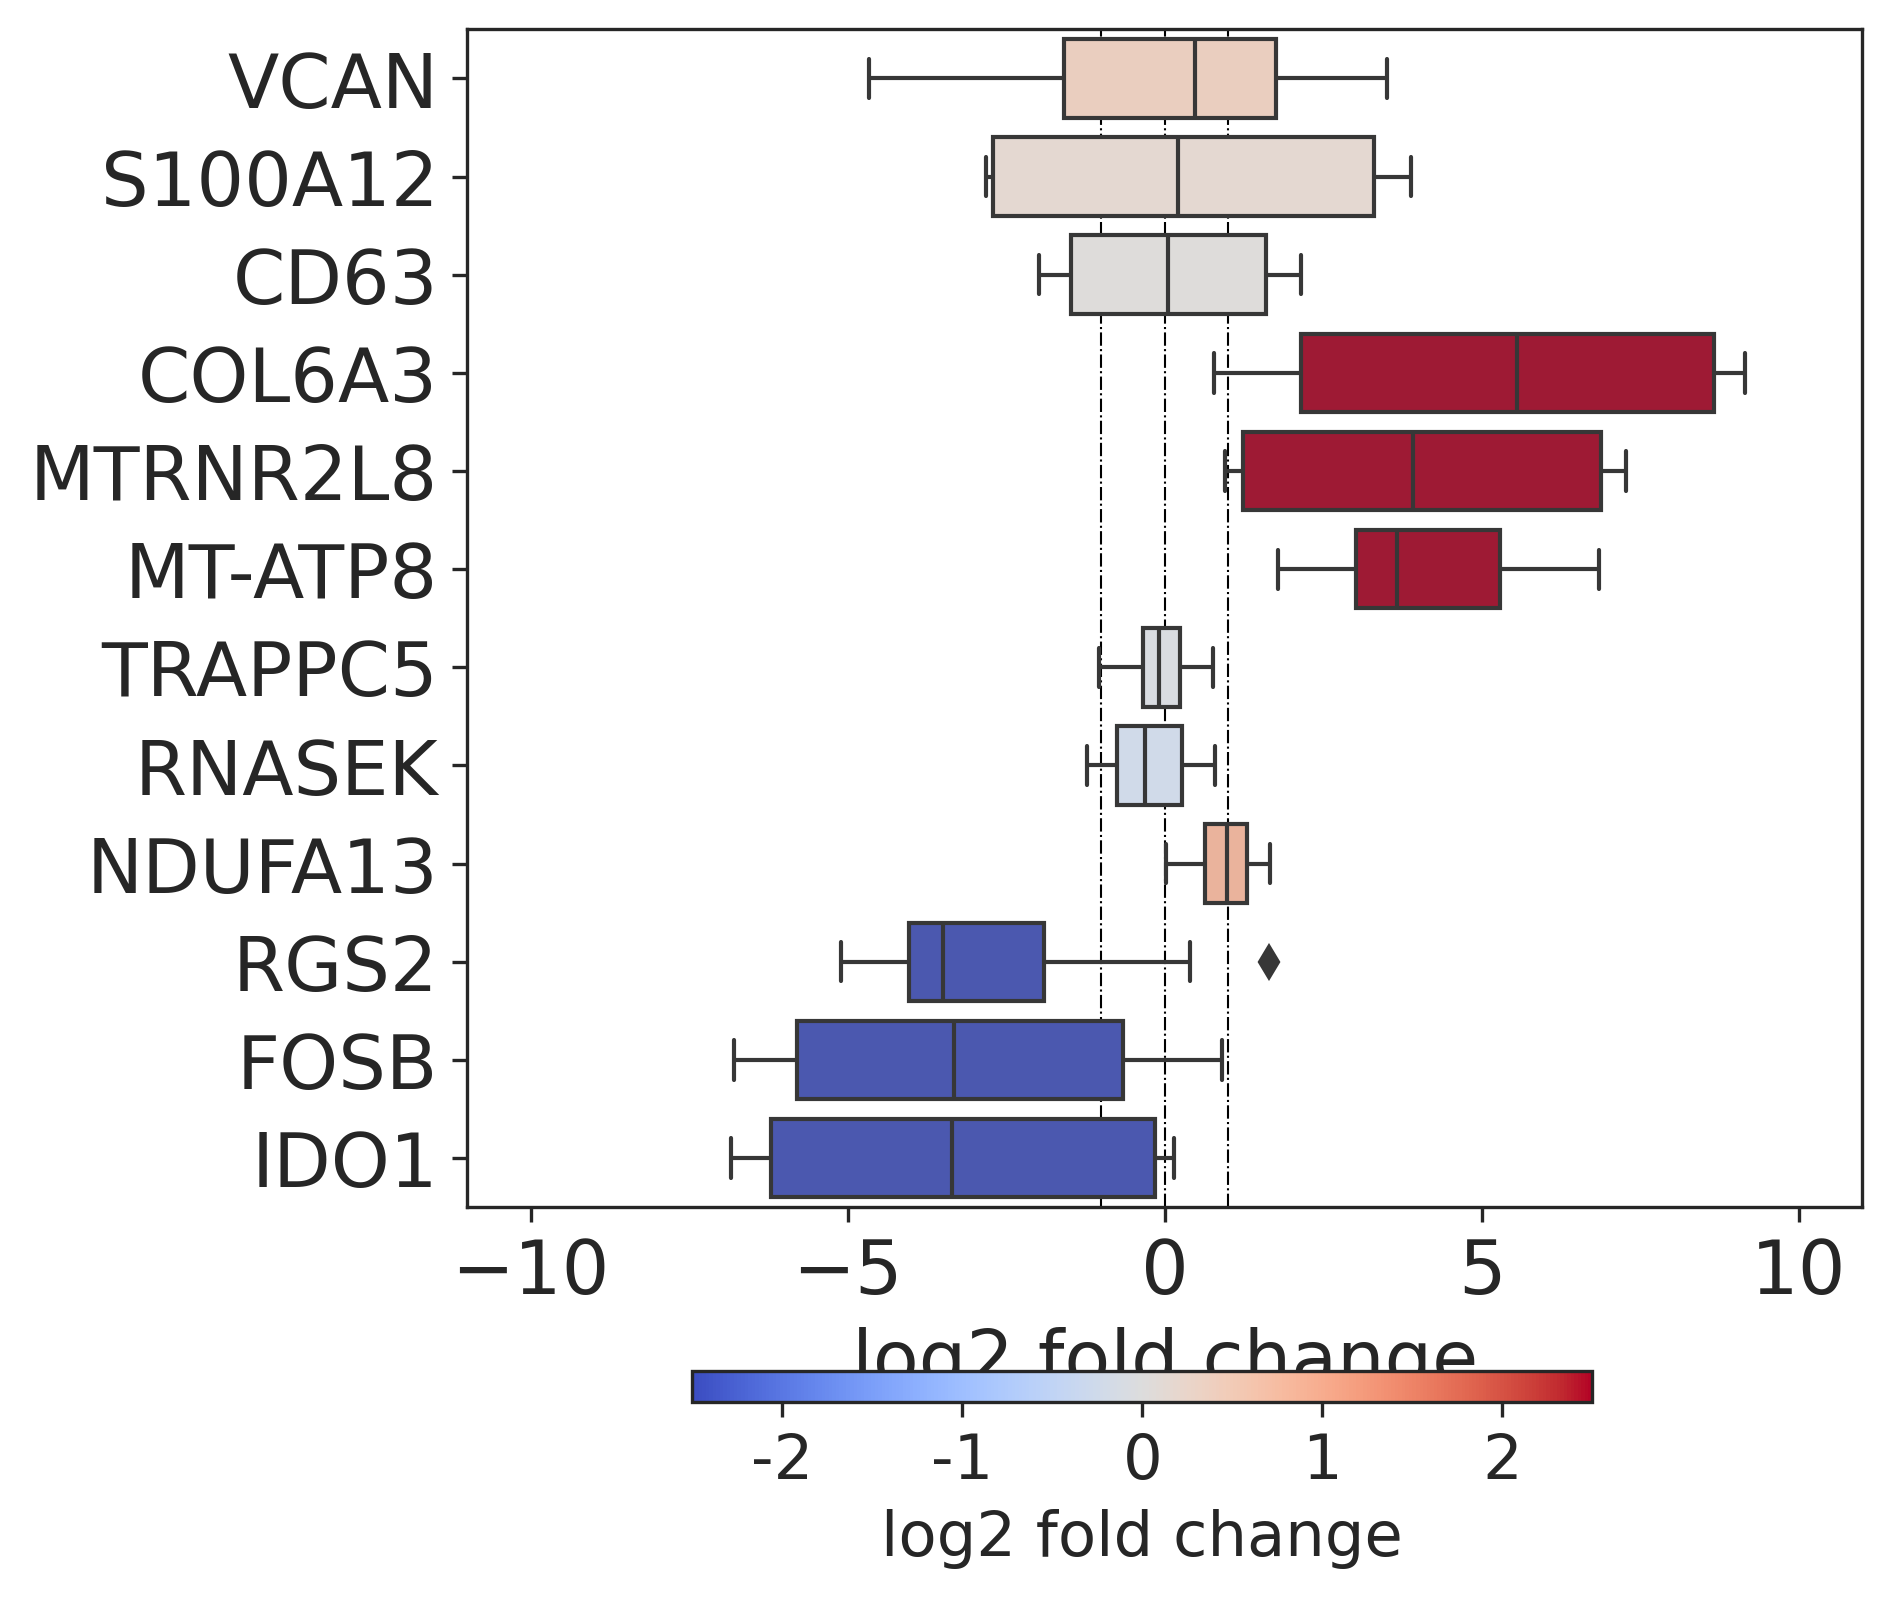

In [193]:
adult_genes = ['VCAN', 'S100A12', 'CD63', 
             'COL6A3', 'MTRNR2L8', 'MT-ATP8', 
             'TRAPPC5', 'RNASEK', 'NDUFA13', 
             'RGS2', 'FOSB', 'IDO1']



pairwise_boxplot(ct_log2FC_a, ['Monocytes'], adult_genes, path='mo_adult_sup.pdf')
pairwise_boxplot(ct_log2FC_a, ['Monocytes'], adult_genes, path='mo_adult_sup.png')

In [22]:
adata_adult = subsetdata(adata, platform ='plate')
adata_adult = normalizedata(adata_adult)
adata_adult = removegenes(adata_adult)

adata_adult = annanote_adult(adata_adult)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [60]:
adata_adult_M = adata_adult[adata_adult.obs.cell_type_new == 'Monocytes']
adata_kid_M = adata_kid[adata_kid.obs.cell_type_new == 'Monocytes']

df, r = pairwise_processing(ct_pair.loc['Monocytes'], ct_pair_a.loc['Monocytes'])
sc.pp.filter_genes(adata_adult_M, min_cells=3)
df = df.loc[[x for x in df.index if x in adata_kid_M.var_names]]

Trying to set attribute `.var` of view, copying.
/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [182]:
mark_list

{'1': ['MTRNR2L12', 'RNASE2', 'FKBP5', 'MT-CYB'],
 '2': ['IFIT1', 'SAMD9', 'EVI2B', 'RHOB'],
 '3': ['SAT1', 'HLA-DRB5', 'HLA-DPA1', 'NBPF26', 'LGALS2', 'HSP90AA1', 'CCL3'],
 '4': ['GBP5',
  'IRF1',
  'GBP1',
  'WARS',
  'GBP2',
  'S100A8',
  'SELL',
  'VAMP5',
  'FCGR1A',
  'ACSL1',
  'PIM1',
  'PSME2',
  'BCL2A1',
  'S100A9',
  'GLIPR2',
  'STAT1',
  'APLP2'],
 '5': ['VCAN', 'S100A12', 'CD63'],
 '6': ['COL6A3', 'MTRNR2L8', 'MT-ATP8'],
 '7': ['TRAPPC5', 'RNASEK', 'NDUFA13'],
 '8': ['RGS2', 'FOSB', 'IDO1']}

{'figure': <Figure size 2100x2100 with 1 Axes>,
 'ax': <AxesSubplot:xlabel='log2 fold change (SD vs D)\nin children', ylabel='log2 fold change (SD vs D)\nin adults'>}

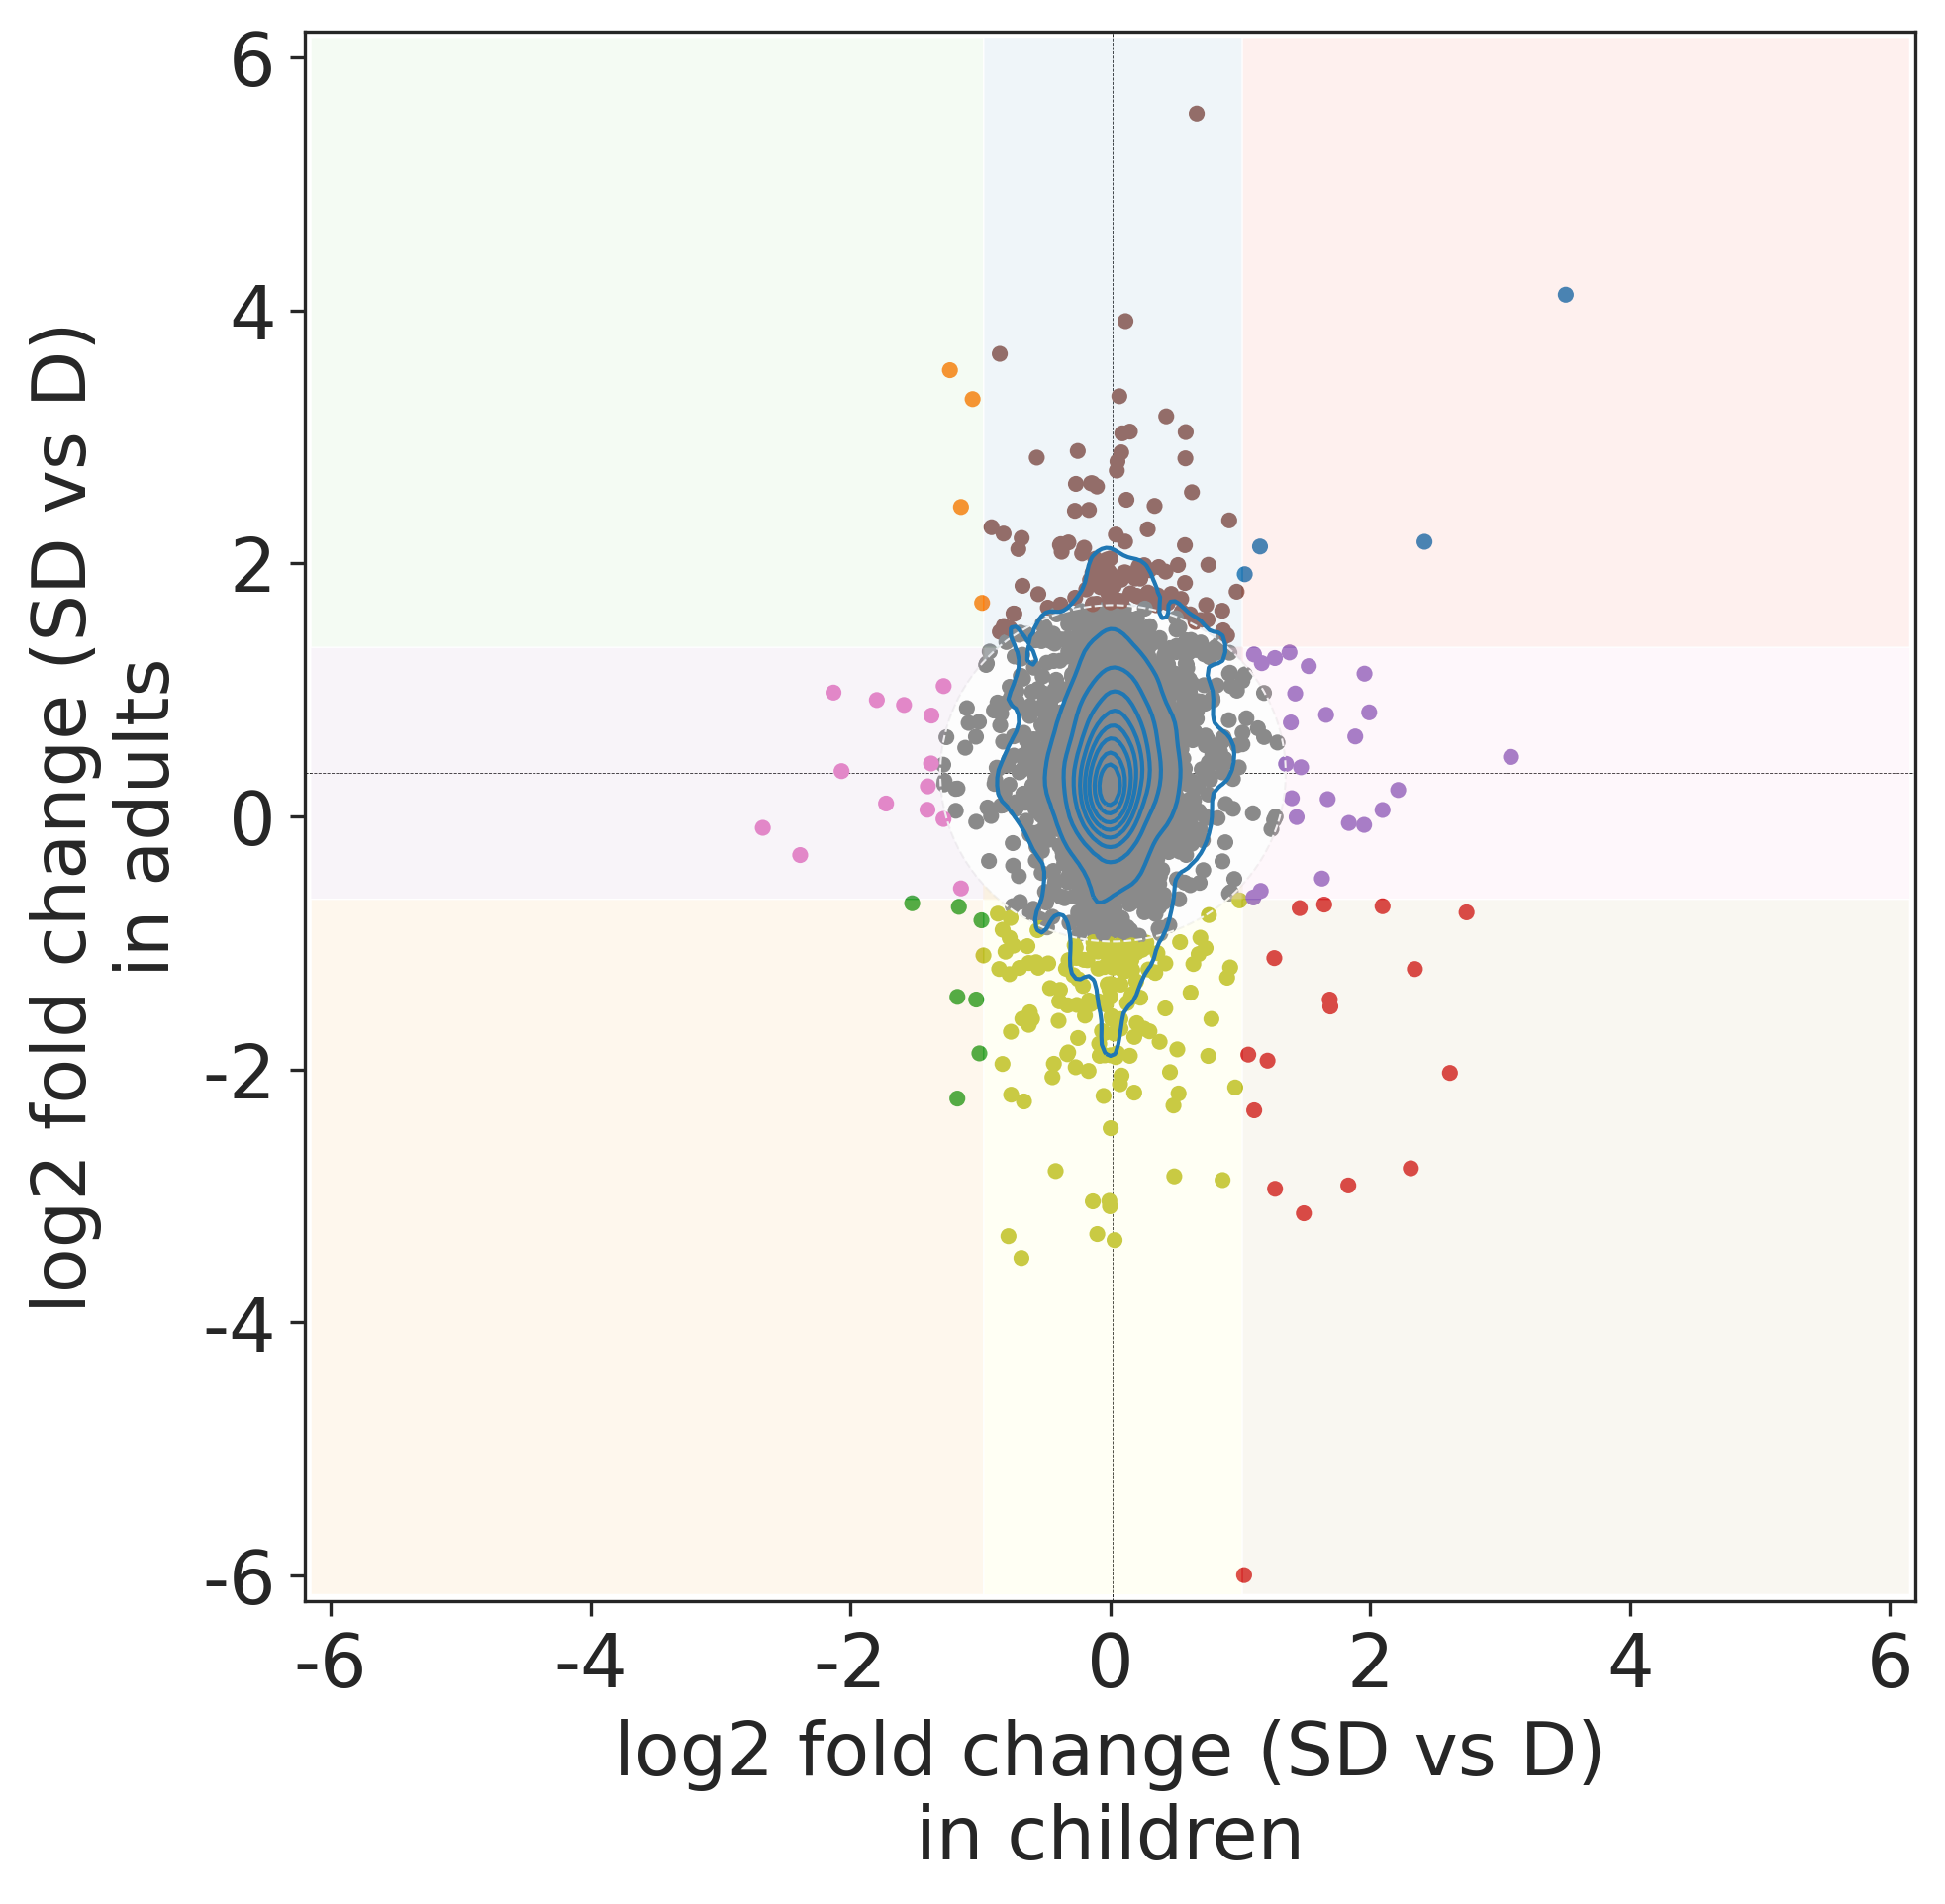

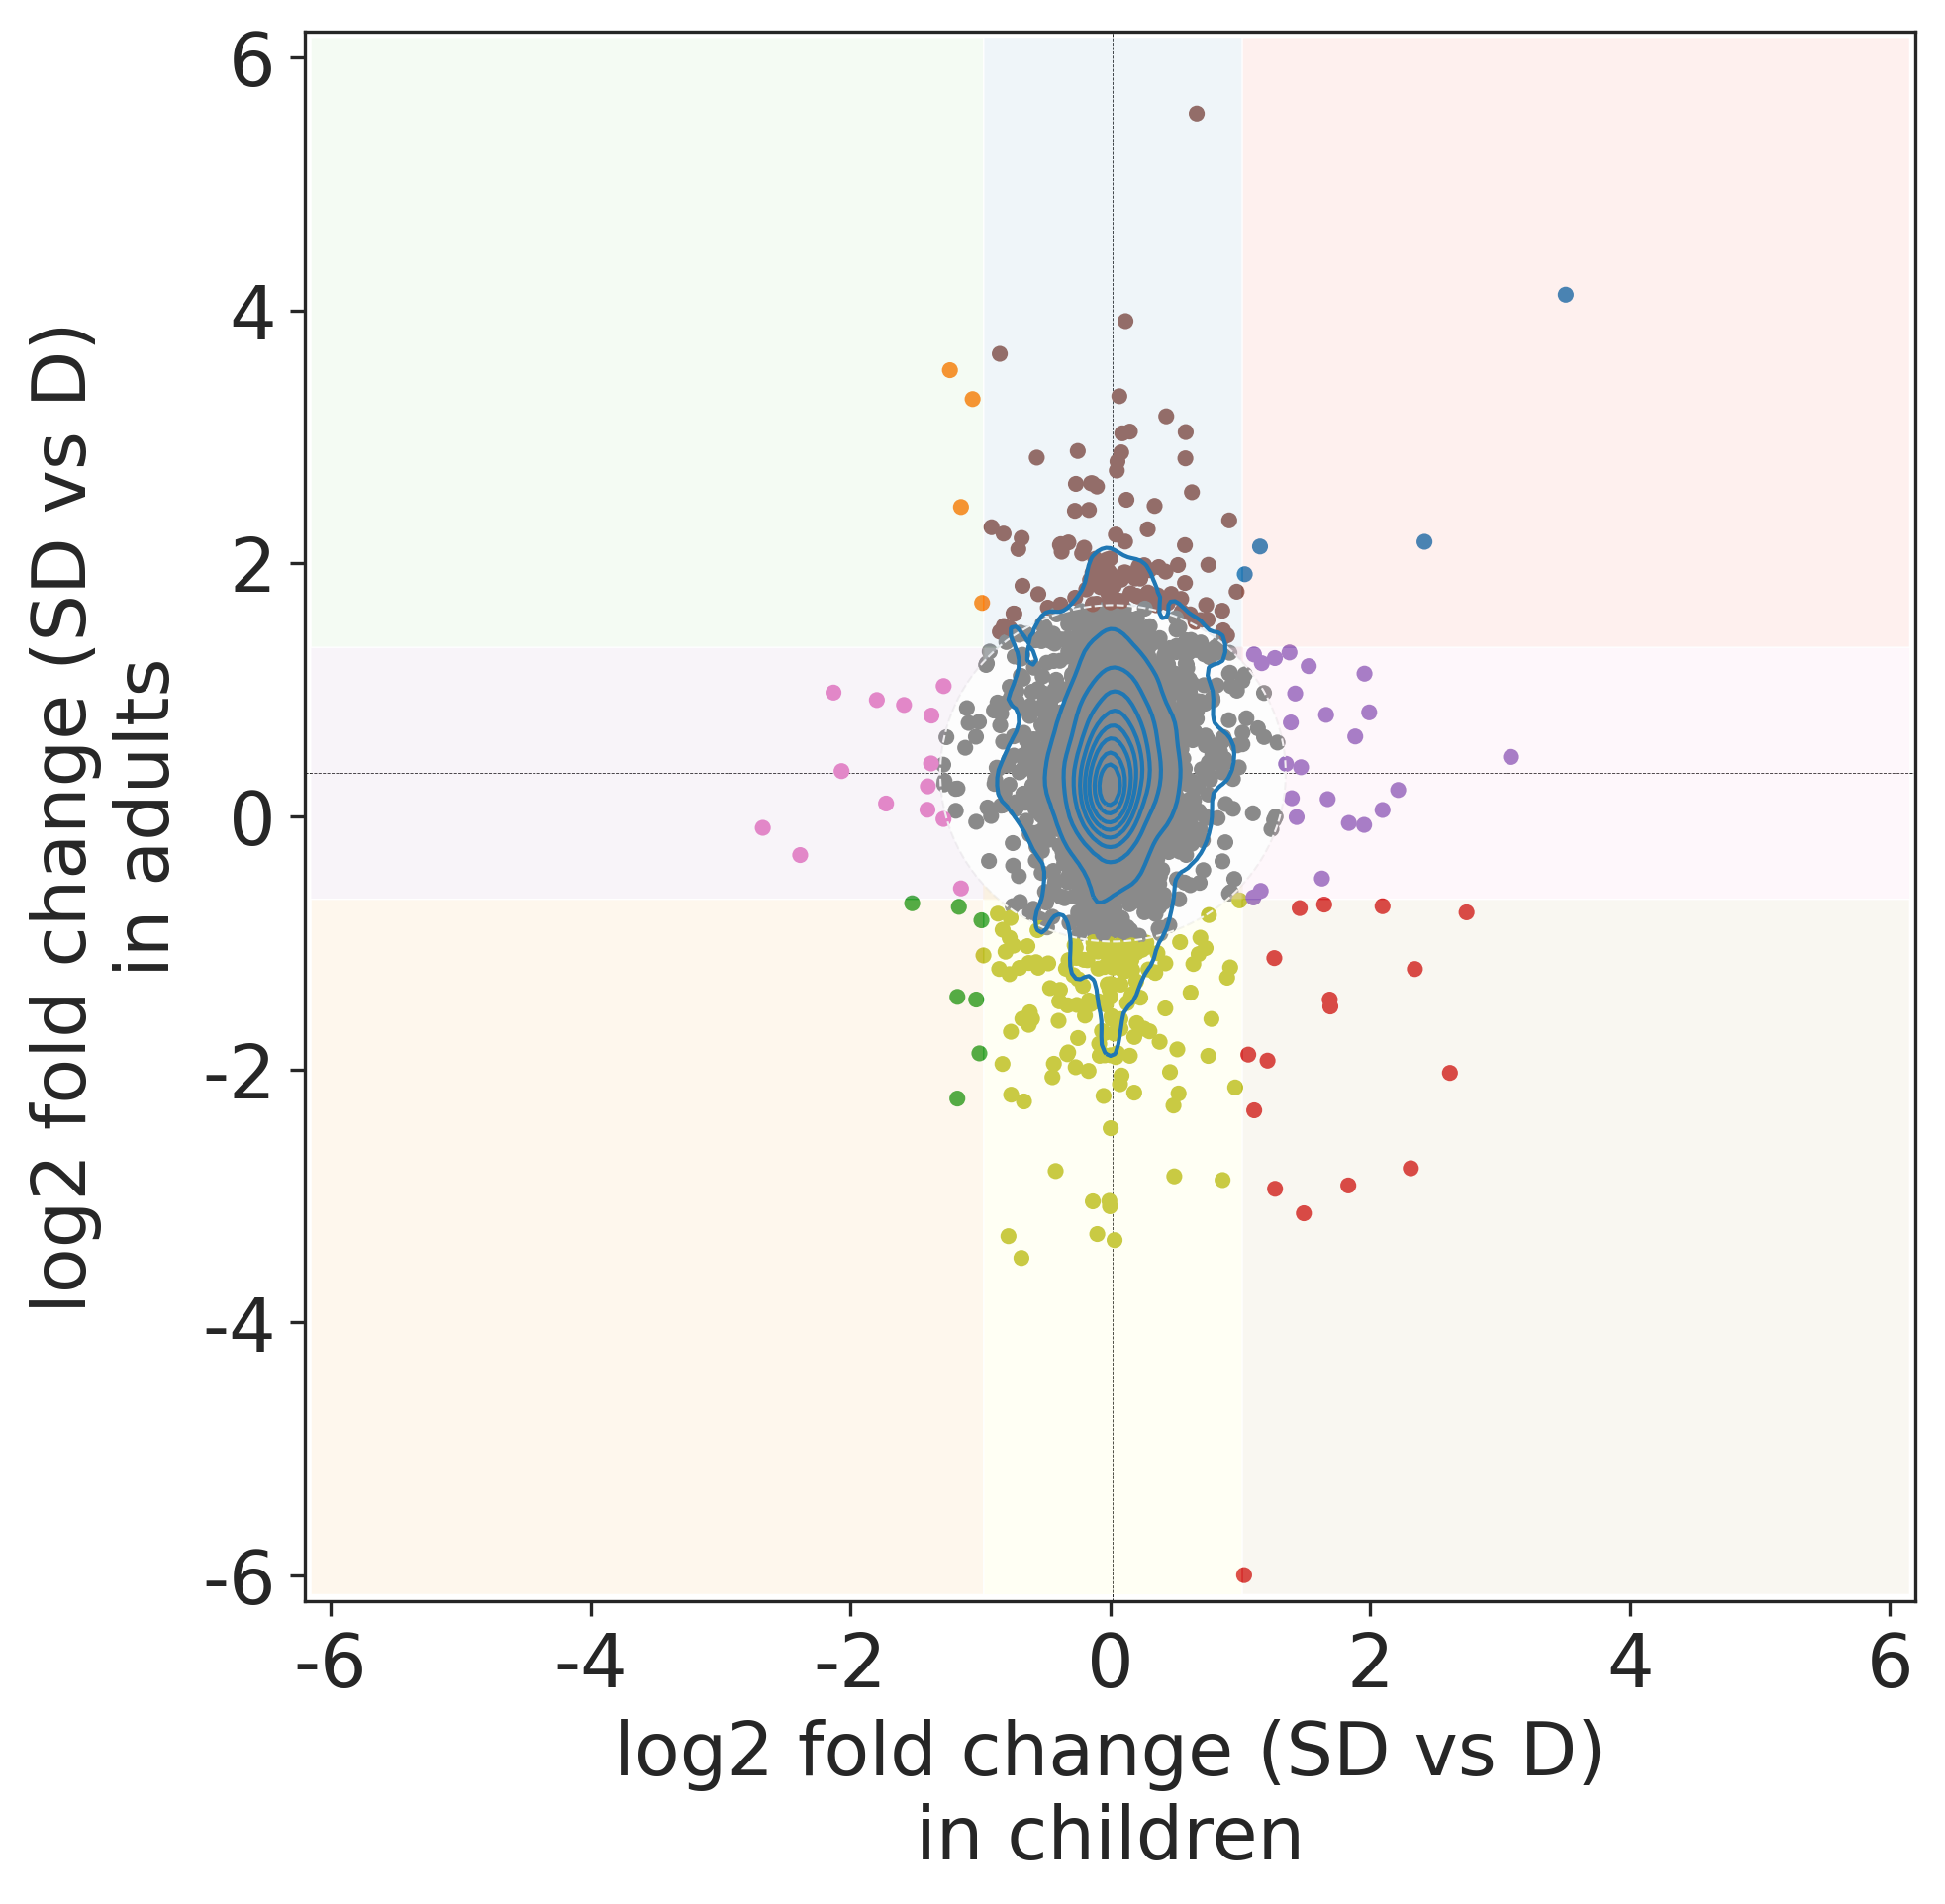

In [61]:
# mark_list = {}
# for m in ['1', '2', '3', '4']:   
#     mark_list[m] = df[df['markers'] == m].sort_values('r', ascending=False).index.tolist()
    
# for m in ['5', '6', '7', '8']:
#     mark_list[m] = df[df['markers'] == m].sort_values('r', ascending=False).index.tolist()[:3]

# import itertools
# marklist = list(itertools.chain.from_iterable(mark_list.values()))

scatter_pairwise(df, r, [], name='DEGs_Monocytes_new.png', xlim=6.2)
scatter_pairwise(df, r, [], name='DEGs_Monocytes_new.pdf', xlim=6.2)

In [62]:
df, r = pairwise_processing(ct_pair.loc['NK cells'], ct_pair_a.loc['NK cells'])
adata_kid_NK = adata_kid[adata_kid.obs.cell_type_new == 'NK cells']
adata_kid_NK = removegenes(adata_kid_NK)
sc.pp.filter_genes(adata_kid_NK, min_cells=3)
df = df.loc[[x for x in df.index if x in adata_kid_NK.var_names]]

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [64]:
mark_list = {}
for m in ['1', '2', '3', '4']:   
    mark_list[m] = df[df['markers'] == m].sort_values('r', ascending=False).index.tolist()

for m in ['5', '6', '7', '8']:
    mark_list[m] = df[df['markers'] == m].sort_values('r', ascending=False).index.tolist()[:3]
    
mark_list

{'1': ['MTRNR2L12', 'CCL5', 'PABPC1', 'GBP5'],
 '2': ['MT-ND3', 'IFI6', 'MT-ATP8', 'FGFBP2'],
 '3': ['BST2', 'KLRB1', 'FCER1G', 'ARPC1B', 'SPON2'],
 '4': ['SELL', 'HSP90AB1', 'HSPA5', 'BZW1', 'COTL1', 'NCL', 'GDI2'],
 '5': ['PCBP1', 'HLA-DPA1', 'CSDE1'],
 '6': ['COL6A3', 'TAOK1', 'MTRNR2L8'],
 '7': ['RPL17', 'RPL26', 'ECH1'],
 '8': ['FOS', 'CORO1A', 'ZFP36']}

{'figure': <Figure size 2100x2100 with 1 Axes>,
 'ax': <AxesSubplot:xlabel='log2 fold change (SD vs D)\nin children', ylabel='log2 fold change (SD vs D)\nin adults'>}

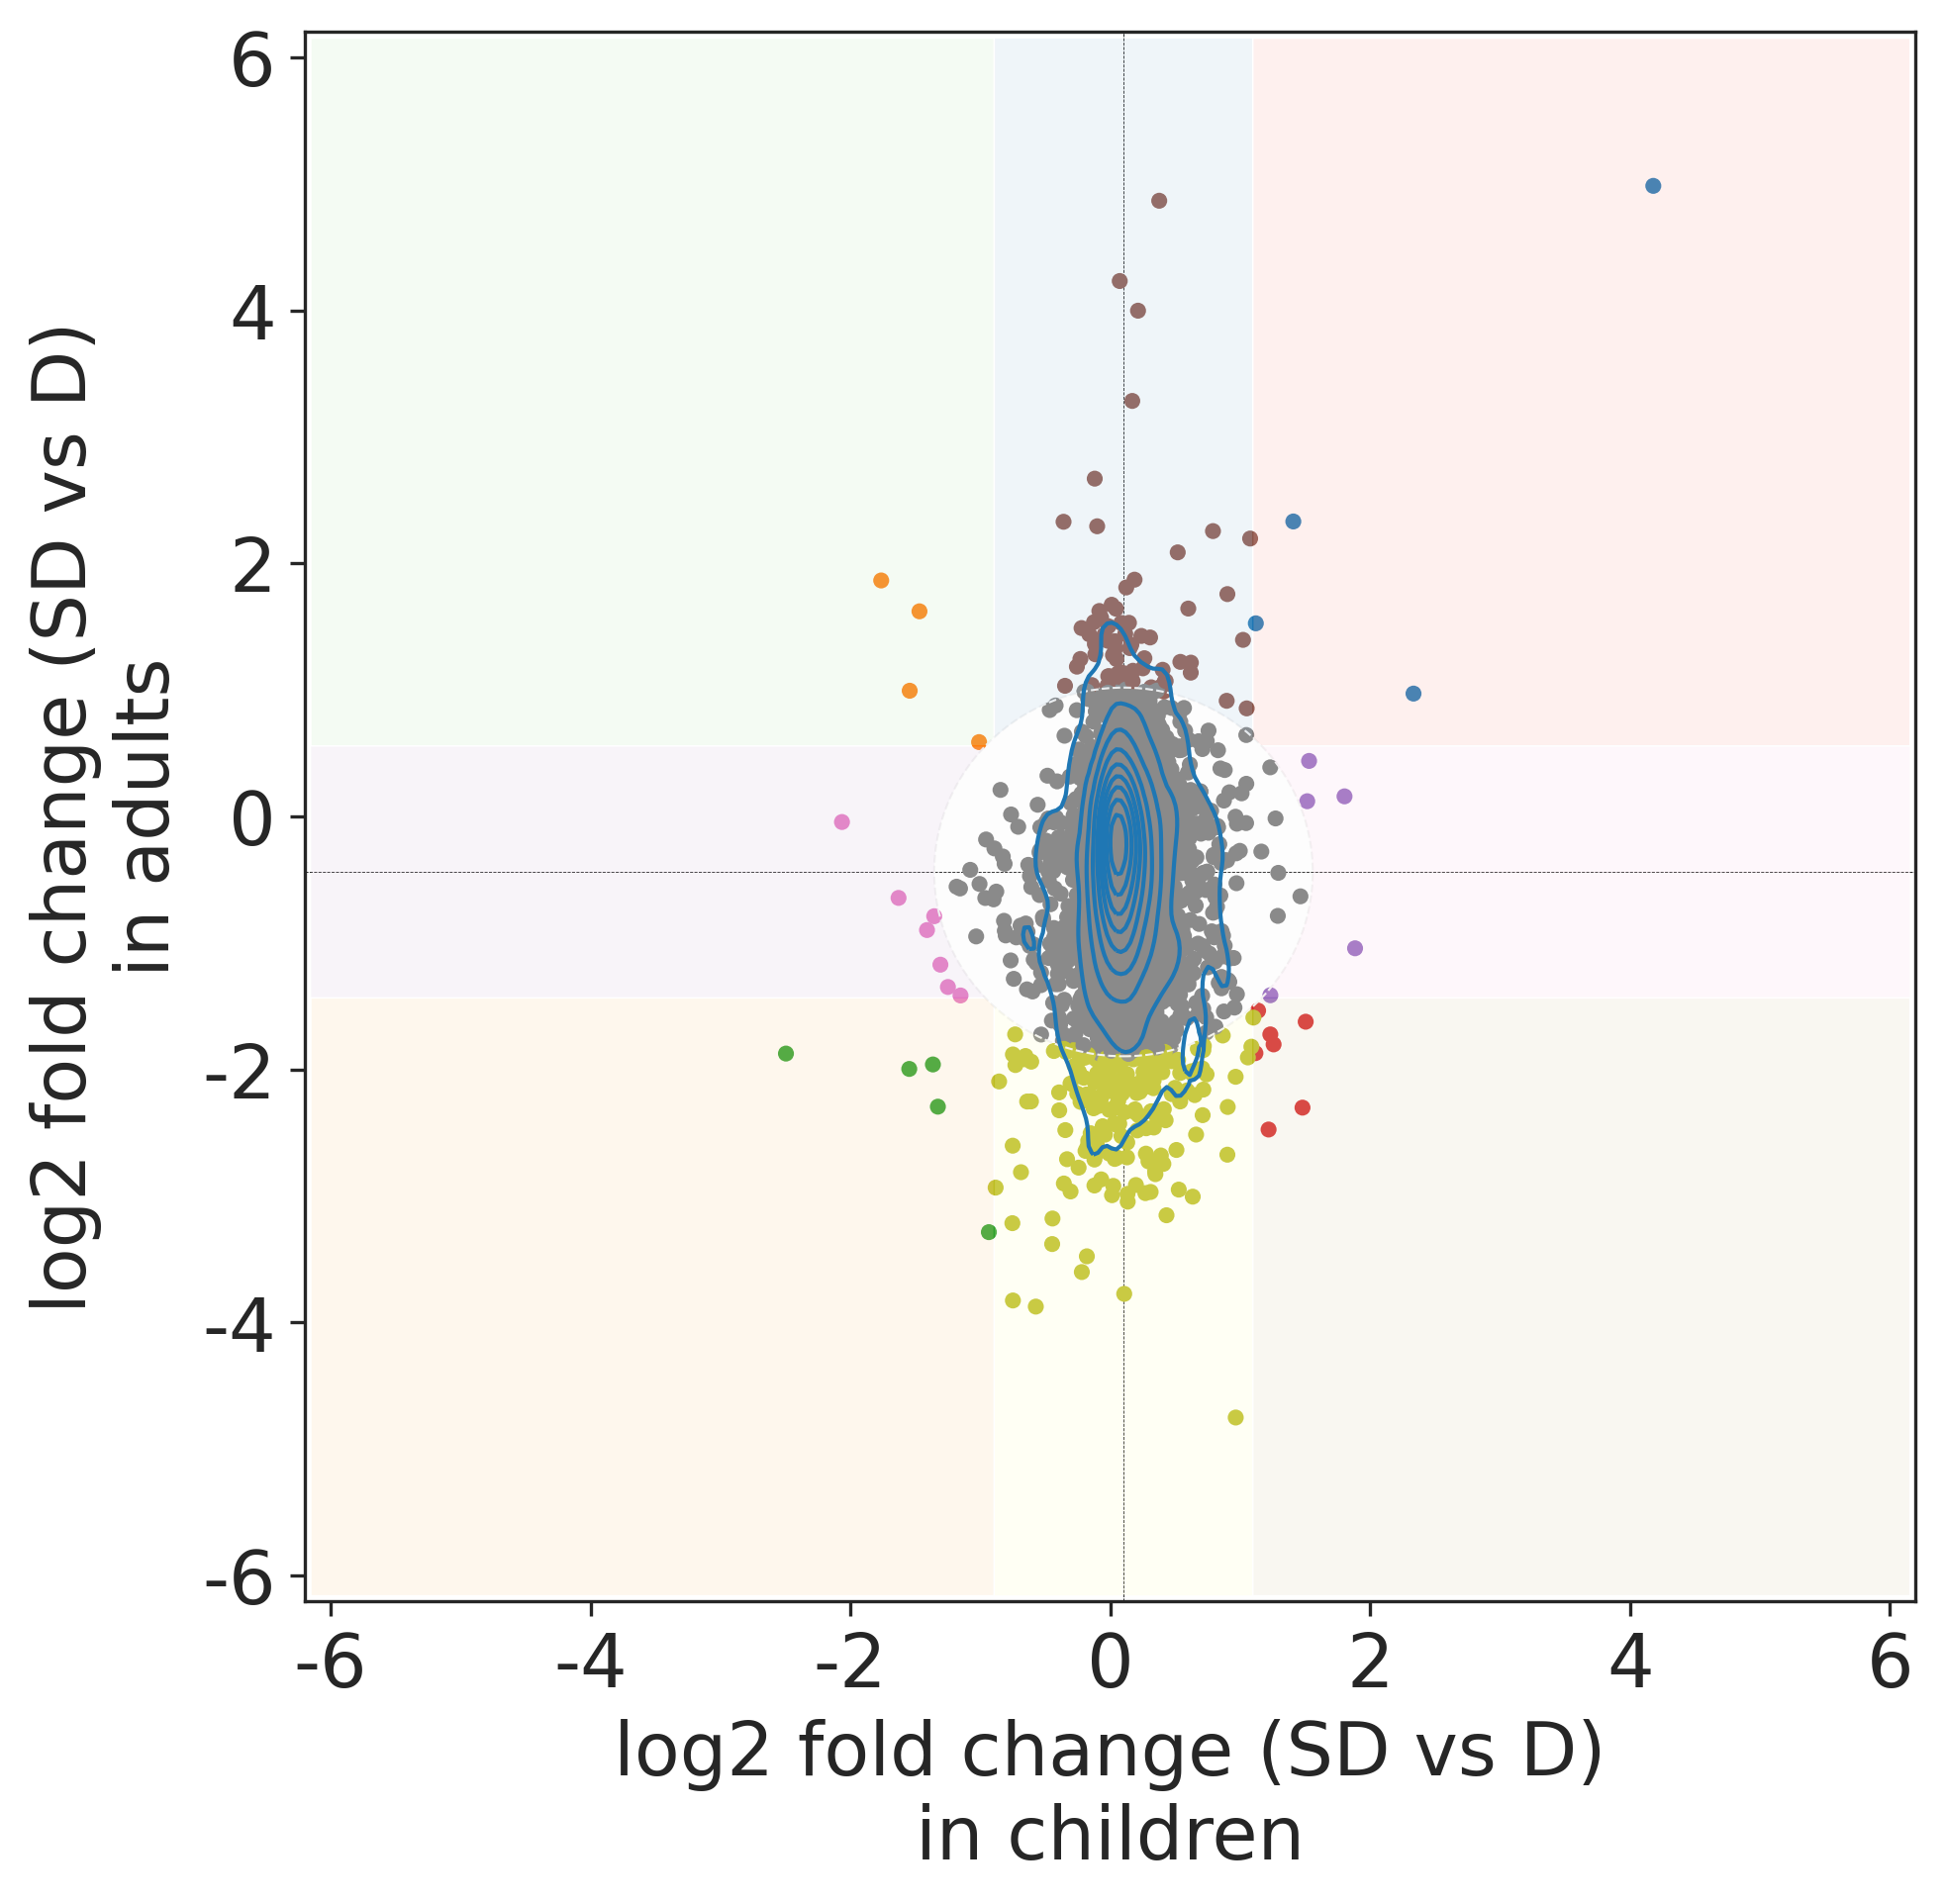

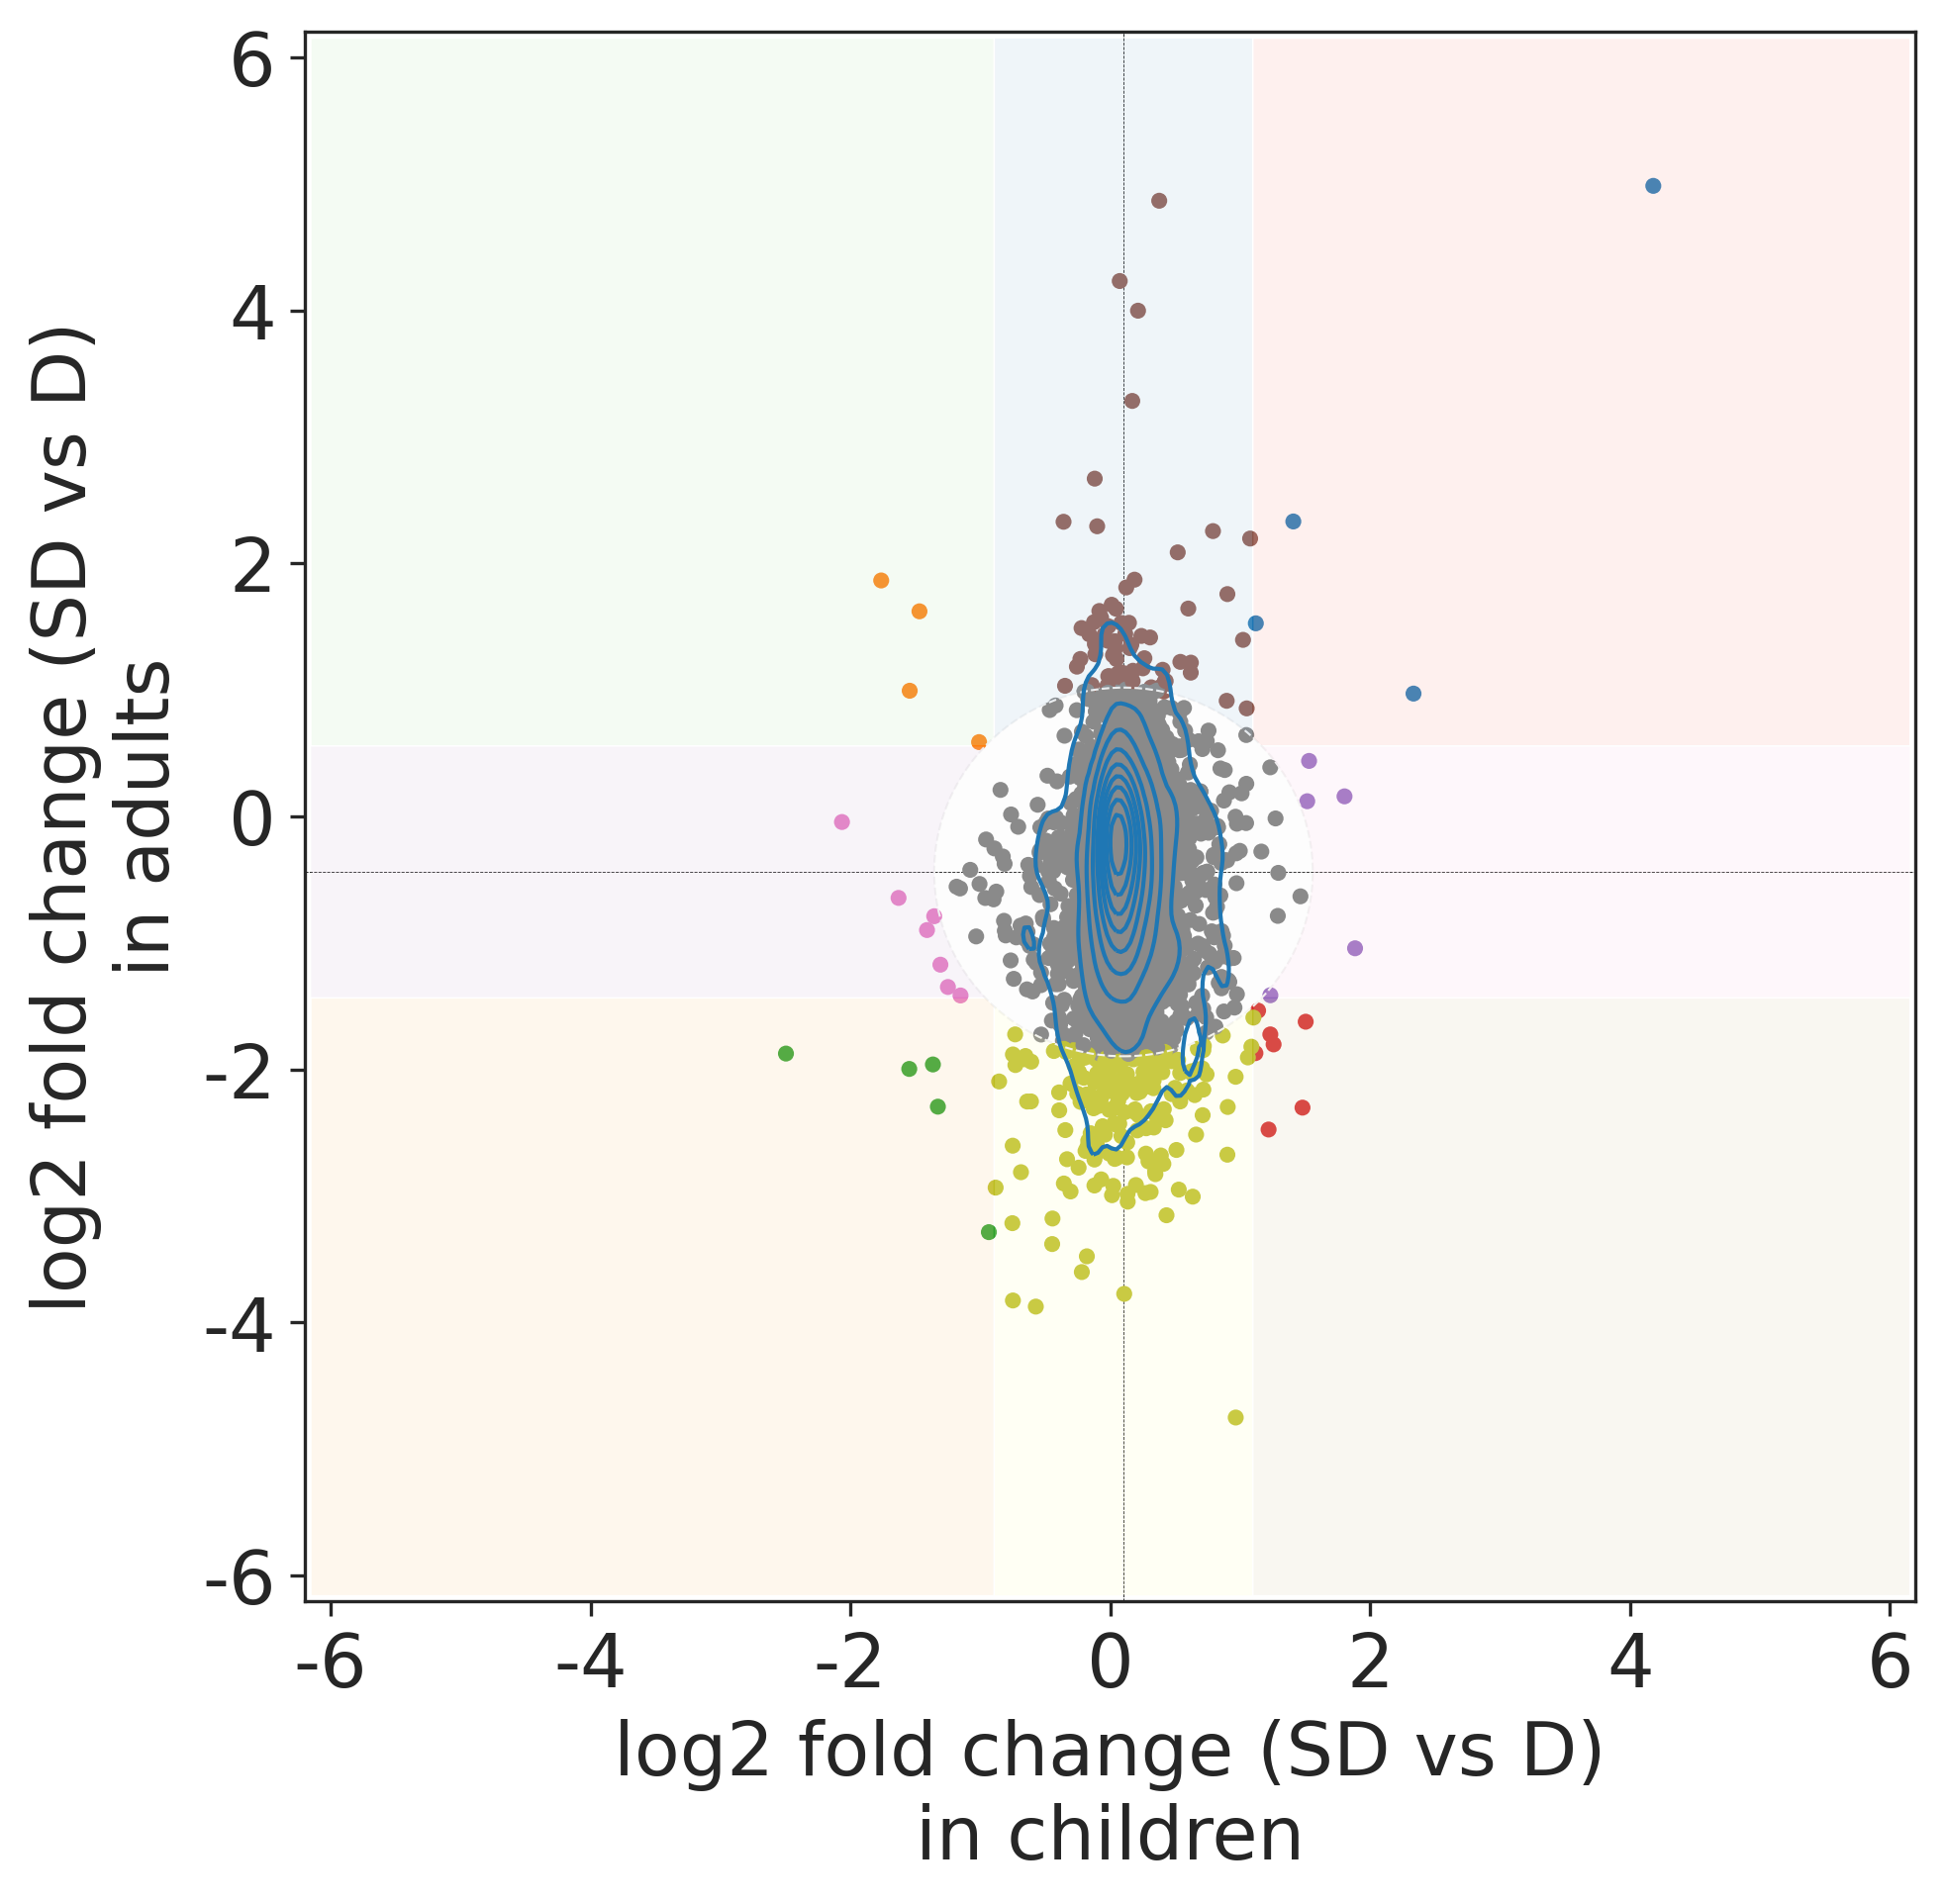

In [63]:
import itertools
marklist = list(itertools.chain.from_iterable(mark_list.values()))

scatter_pairwise(df, r, [], name='DEGs_NK_new.png', xlim=6.2)
scatter_pairwise(df, r, [], name='DEGs_NK_new.pdf', xlim=6.2)